In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd


We consider the train and test split provided by the authors of the dataset, using a 10% of the training data as validation.  We want to test the generalization of a model trained with and without stain normalization and augmentation. Hence we create data loaders with and without applying the method RandStainNA. We additionally include random rotation, flipping, small scaling and gaussian blur as augmentations. Data are from https://bmirds.github.io/MHIST/. Code for RandStainNA from https://github.com/yiqings/RandStainNA?tab=readme-ov-file. 

In [4]:
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,  WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from randstainna import RandStainNA


# Step 1: Set up paths
base_dir = 'data/MHIST'
extracted_folder = os.path.join(base_dir, 'extracted_images')
annotations_path = os.path.join(base_dir, 'annotations.csv')

# Step 2: Extract the images from the zip file
zip_path = os.path.join(base_dir, 'images.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Step 3: The extracted images are inside the 'images' subfolder
image_folder = os.path.join(extracted_folder, 'images')

# Step 4: Load annotations from CSV
annotations_df = pd.read_csv(annotations_path)

# Step 5: Create the directories for train and test sets
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Step 6: Move the images into train and test folders according to the annotations
def move_images_to_folder(annotations, dest_folder):
    for _, row in annotations.iterrows():
        image_name = row['Image Name']
        image_path = os.path.join(image_folder, image_name)
        shutil.move(image_path, os.path.join(dest_folder, image_name))

move_images_to_folder(annotations_df[annotations_df['Partition'] == 'train'], train_dir)
move_images_to_folder(annotations_df[annotations_df['Partition'] == 'test'], test_dir)

# Step 6: Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, annotations_df, image_dir, transform=None, stain_normalizer=None):
        self.annotations_df = annotations_df
        self.image_dir = image_dir
        self.transform = transform
        self.stain_normalizer = stain_normalizer
        # Map Majority Vote Label to binary labels (0 for HP, 1 for SSA)
        self.label_map = {'SSA': 1, 'HP': 0}
        
    def __len__(self):
        return len(self.annotations_df)
    
    def __getitem__(self, idx):
        # Get the image filename and corresponding label
        row = self.annotations_df.iloc[idx]
        image_name = row['Image Name']
        label = self.label_map[row['Majority Vote Label']]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')
        
        # Apply stain normalization (RandStain)
        if self.stain_normalizer:
            image = self.stain_normalizer(image)  # Apply RandStain normalization
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        return image, label

# RandStain normalization setup
randstain = RandStainNA(
            yaml_file="CRC_LAB_randomTrue_n0.yaml",
            std_hyper=-0.3,
            probability=1.0,
            distribution="normal",
            is_train=True,
        )

# Train transformations
train_transform_randstain = transforms.Compose([
    randstain,
    transforms.ToTensor(),                                    # Convert to tensor
    transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),                     # Random vertical flip    
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.2)),
    transforms.Resize((224, 224)),                            # Resize to 224x224
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),  # Apply Gaussian blur
])

train_transform_unormalized = transforms.Compose([
    transforms.ToTensor(),                                    # Convert to tensor
    transforms.RandomHorizontalFlip(p=0.5),                   # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),                     # Random vertical flip    
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.2)),
    transforms.Resize((224, 224)),                            # Resize to 224x224
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),  # Apply Gaussian blur
])

# Test/Validation transformations
test_transform_randstain = transforms.Compose([
    randstain,
    transforms.ToTensor(),    
])

# Test/Validation transformations
test_transform_unormalized = transforms.Compose([
    transforms.ToTensor(),    
])

# Step 7: Split train set into training and validation
train_annotations = annotations_df[annotations_df['Partition'] == 'train']
train_df, val_df = train_test_split(train_annotations, test_size=0.1, stratify=train_annotations['Majority Vote Label'], random_state=42)

# Step 8: Count class frequencies and compute class weights
class_counts = train_annotations['Majority Vote Label'].value_counts()

# Calculate class probabilities
total_samples = len(train_annotations)
p_hp = class_counts['HP'] / total_samples  # Probability of class HP
p_ssa = class_counts['SSA'] / total_samples  # Probability of class SSA
class_ratio = p_hp / p_ssa

# Calculate log-odds for bias initialization
bias_hp = torch.log(torch.tensor(p_hp / (1 - p_hp)))
bias_ssa = torch.log(torch.tensor(p_ssa / (1 - p_ssa)))

# Define class weights for loss function
class_weights = {0: 1 / p_hp, 1: 1 / p_ssa}
class_weights_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)

# Compute log-odds for bias initialization
log_odds_hp = torch.log(torch.tensor(p_hp / (1 - p_hp)))  # Log-odds for HP
log_odds_ssa = torch.log(torch.tensor(p_ssa / (1 - p_ssa)))  # Log-odds for SSA


y = train_df['Majority Vote Label'].map({'HP': 0, 'SSA': 1}).values
counts = np.bincount(y)
labels_weights = 1. / counts
weights = labels_weights[y]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(total_samples))


batch_size = 32

# Step 9: Create datasets
train_dataset_stain = CustomDataset(train_df, train_dir, train_transform_randstain)
val_dataset_stain = CustomDataset(val_df, train_dir, test_transform_randstain)  # Use test_transform for validation
test_dataset_stain = CustomDataset(annotations_df[annotations_df['Partition'] == 'test'], test_dir, test_transform_randstain)
train_dataset_nostain = CustomDataset(train_df, train_dir, train_transform_unormalized)
val_dataset_nostain = CustomDataset(val_df, train_dir, test_transform_unormalized)  # Use test_transform for validation
test_dataset_nostain = CustomDataset(annotations_df[annotations_df['Partition'] == 'test'], test_dir, test_transform_unormalized)
    

# Step 10: Create DataLoaders
train_loader_stain = DataLoader(train_dataset_stain, batch_size=batch_size, shuffle=False,sampler=sampler)
val_loader_stain = DataLoader(val_dataset_stain, batch_size=batch_size, shuffle=False)
test_loader_stain = DataLoader(test_dataset_stain, batch_size=batch_size, shuffle=False)

train_loader_nostain = DataLoader(train_dataset_nostain, batch_size=batch_size, shuffle=False,sampler=sampler)
val_loader_nostain = DataLoader(val_dataset_nostain, batch_size=batch_size, shuffle=False)
test_loader_nostain = DataLoader(test_dataset_nostain, batch_size=batch_size, shuffle=False)

Here we can see 5 transformations in the training datasets. The first row corresponds to the RandStainNA. Essentially the only difference is the colour and brightness variations from RandStainNA. 

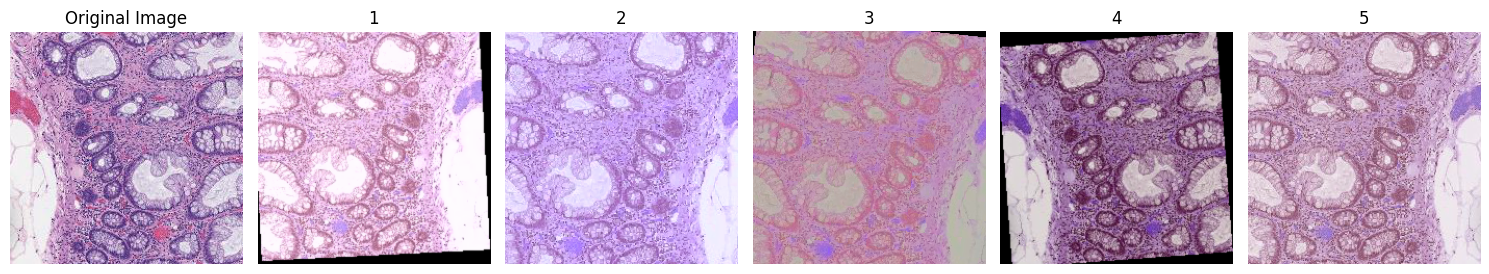

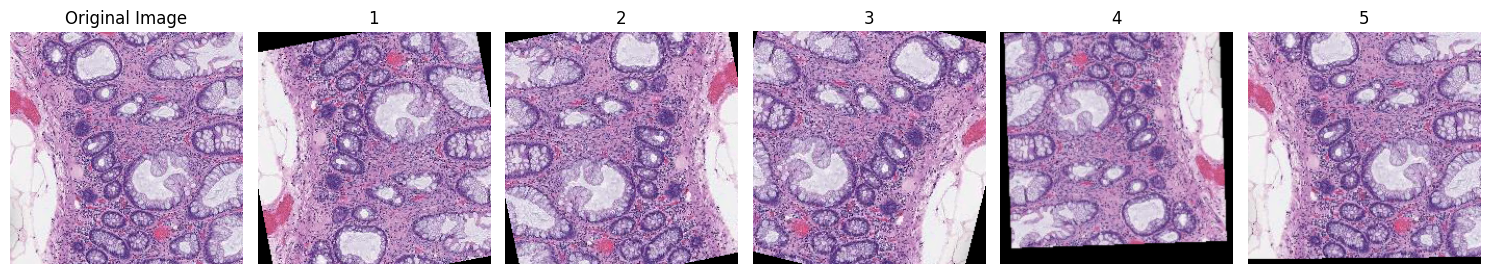

In [ ]:
# Plot one sample before and after augmentation
import matplotlib.pyplot as plt


# Get one sample from the training dataset
sample_image = Image.open(os.path.join(train_dir, train_annotations.iloc[4]['Image Name']))  # Original image and label
# Convert the image to a NumPy array
image_array = np.array(sample_image)
# Check the data type

# Get the range of pixel values
min_val = image_array.min()
max_val = image_array.max()

# Apply augmentation multiple times to observe the effect
augmented_images = [train_transform_randstain(sample_image) for _ in range(5)]
aug_image = augmented_images[0].permute(1, 2, 0).numpy()

min_val = aug_image.min()
max_val = aug_image.max()

# Plot original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes[0].imshow(sample_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, aug_image in enumerate(augmented_images):
    axes[i + 1].imshow(aug_image.permute(1, 2, 0).numpy())
    axes[i + 1].set_title(f"{i+1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

# Apply augmentation multiple times to observe the effect
augmented_images = [train_transform_unormalized(sample_image) for _ in range(5)]
aug_image = augmented_images[0].permute(1, 2, 0).numpy()


# Plot original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes[0].imshow(sample_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

for i, aug_image in enumerate(augmented_images):
    axes[i + 1].imshow(aug_image.permute(1, 2, 0).numpy())
    axes[i + 1].set_title(f"{i+1}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()

We create methods to train, test the ROC, and plotting. With mixture of experts we can additionally plot their utilization. The train function includes all the standard DL training tricks.

In [74]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Accelerator for distributed/mixed-precision training
accelerator = Accelerator()
device = accelerator.device
print(f'Device is {device}')

def train(
    model,
    train_loader,
    val_loader,
    criterion=None,
    epochs=10,
    base_lr=1e-4,
    batch_size=8,
    weight_decay=1e-4,
    max_grad_norm=1.0,
    save_path=None,
    stop_after_num_epochs=None,
    use_scheduler=True,  # New parameter to enable/disable scheduler
    val_acc_threshold=0.9,  # Validation accuracy termination threshold
    val_rec_threshold=0.9   # Validation recall termination threshold
):
    """
    Improved training loop with optional OneCycleLR, logging, and debugging tools, 
    and termination criterion based on validation accuracy and recall.
    """

    # Linear scaling of learning rate based on batch size
    base_batch_size = 8
    scaled_lr = base_lr * (batch_size / base_batch_size)

    # Default criterion: CrossEntropyLoss
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    # Optimizer setup
    optimizer = AdamW(model.parameters(), lr=scaled_lr, weight_decay=weight_decay)

    # Scheduler setup (if enabled)
    scheduler = None
    if use_scheduler:
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scaled_lr,
            steps_per_epoch=len(train_loader),
            epochs=epochs,
            pct_start=0.3,  # Portion of the cycle for warm-up
            anneal_strategy='cos',
            final_div_factor=1e4
        )

    # Prepare model, optimizer, and loaders with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    # Lists for tracking metrics
    train_losses, train_accuracies, train_recalls = [], [], []
    val_losses, val_accuracies, val_recalls = [], [], []

    # Training loop
    for epoch in range(epochs):
        if stop_after_num_epochs is not None and epoch > stop_after_num_epochs:
            break
        model.train()
        running_loss, running_corrects, total_samples = 0.0, 0, 0
        running_recall = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass
                accelerator.backward(loss)

                # Gradient clipping
                if max_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

                optimizer.step()

                # Step scheduler after each batch (if enabled)
                if use_scheduler and scheduler is not None:
                    scheduler.step()

                # Metrics calculation
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_corrects += (preds == labels).sum().item()
                total_samples += labels.size(0)

                # Calculate recall
                running_recall += recall_score(labels.cpu(), preds.cpu(), pos_label=1, zero_division=0)

                # Update progress bar
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=running_corrects / total_samples)
                pbar.update(1)

        # Log training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / total_samples
        train_recall = running_recall / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_recalls.append(train_recall)

        print(f"\tEpoch {epoch + 1} Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}, Recall = {train_recall:.4f}")
        
        # model.enhancement_block.get_utilization()

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss, val_corrects, total_val_samples = 0.0, 0, 0
            val_recall = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    val_corrects += (preds == labels).sum().item()
                    total_val_samples += labels.size(0)

                    # Calculate recall
                    val_recall += recall_score(labels.cpu(), preds.cpu(), pos_label=1, zero_division=0)

            val_loss /= len(val_loader)
            val_acc = val_corrects / total_val_samples
            val_recall /= len(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            val_recalls.append(val_recall)

            print(f"\tEpoch {epoch + 1} Validation: Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}, Recall = {val_recall:.4f}")

            # Check termination criteria
            if val_acc >= val_acc_threshold and val_recall >= val_rec_threshold:
                print(f"Stopping early: Validation accuracy ({val_acc:.4f}) and recall ({val_recall:.4f}) met thresholds.")
                break

        # Save model checkpoint
        if save_path:
            accelerator.save(model.state_dict(), f"{save_path}/epoch_{epoch + 1}.pth")

    print("Training Complete!")

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_recalls, val_recalls)



def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_recalls, val_recalls):
    """
    Plots the training and validation losses, accuracies, and recalls in one row.
    """
    plt.figure(figsize=(18, 6))  # Wider figure for three plots in one row

    # Plotting losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting accuracies
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plotting recalls
    plt.subplot(1, 3, 3)
    plt.plot(train_recalls, label='Training Recall')
    plt.plot(val_recalls, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

def test_roc(model, test_loader, device, show_expert_util= False):
    # Set the model to evaluation mode
    model.eval()
    if show_expert_util:
        model.enhancement_block.reset_utilization()


    all_labels = []
    all_preds = []
    all_probs = []

    # No gradient computation for testing
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Get probabilities (softmax output)
            probs = F.softmax(outputs, dim=1)  # Applying softmax to get class probabilities

            # Collect true labels, predicted labels, and predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Calculate recall
    recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
    print(f"Test Recall: {recall * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC curve and AUC
    # If it's a binary classification problem, select the probabilities for the positive class (index 1)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])  # For binary classification
    auc = roc_auc_score(all_labels, all_probs[:, 1])  # AUC calculation

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    if show_expert_util:
        model.enhancement_block.get_utilization()

    return accuracy, recall, cm, auc, fpr, tpr

Device is mps


As model, we essentially consider a backbone feature extraction for vision such as ResNet18 and ViT_b_16. On top of the backbone and before the classification layers, we can include an optional block that enhances the feature map, such as Squeeze Excitation and Mixture of Experts. Then we add a classifer that is modular and can stretch to multiple layers (we end up using a single Linear layer with dropped out input).  

In [79]:
import math


class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=None, dropout_rate=0.5, activation=nn.ReLU):
        super(Classifier, self).__init__()
        layers = []
        
        if hidden_dims:
            for dim in hidden_dims:
                layers.append(nn.Linear(input_dim, dim))
                layers.append(activation())
                layers.append(nn.Dropout(dropout_rate))
                input_dim = dim
        else:
            layers.append(nn.Dropout(dropout_rate))


        self.final_layer = nn.Linear(input_dim, num_classes)
        layers.append(self.final_layer)
        self.classifier = nn.Sequential(*layers)

    def initialize_bias(self, class_probs):
        if len(class_probs) != self.final_layer.out_features:
            raise ValueError("The length of class_probs must match the number of classes.")
        
        logits = [math.log(prob / (1 - prob)) for prob in class_probs]
        with torch.no_grad():
            self.final_layer.bias.copy_(torch.tensor(logits))
        print("Bias initialized based on class probabilities:", class_probs)

    def forward(self, x):
        return self.classifier(x)


class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16, use_max_pool=True, activation='silu'):
        super(SEBlock, self).__init__()
        self.use_max_pool = use_max_pool
        
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.activation = nn.ReLU(inplace=True) if activation == 'relu' else nn.SiLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, *spatial_dims = x.size()
        avg_pool = torch.mean(x, dim=[2, 3], keepdim=False) if spatial_dims else x
        if self.use_max_pool and spatial_dims:
            max_pool = torch.amax(x, dim=[2, 3], keepdim=False)
            avg_pool += max_pool
        x_se = self.fc1(avg_pool)
        x_se = self.activation(x_se)
        x_se = self.fc2(x_se)
        x_se = self.sigmoid(x_se).view(b, c, 1, 1)
        return x * x_se


class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x) * x
        avg_out = torch.mean(ca, dim=1, keepdim=True)
        max_out, _ = torch.max(ca, dim=1, keepdim=True)
        sa = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa) * ca
        return sa

class MoEBlock(nn.Module):
    def __init__(self, input_dim, num_experts=4, top_k=2, output_dim=None, temperature=1.0, reduction=4):
        super(MoEBlock, self).__init__()
        self.num_experts = num_experts
        self.top_k = top_k
        self.output_dim = output_dim or input_dim
        self.temperature = temperature
        self.reduction = reduction

        # Gate Network
        self.gate = nn.Sequential(
            nn.Conv2d(input_dim, input_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(input_dim, num_experts, kernel_size=1)
        )

        # Experts with channel reduction
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(input_dim, input_dim // reduction, kernel_size=1),  # Reduction in channels
                nn.ReLU(),
                nn.Conv2d(input_dim // reduction, self.output_dim, kernel_size=1)  # Restore output_dim
            ) for _ in range(num_experts)
        ])

        # Utilization tracking
        self.register_buffer('utilization', torch.zeros(num_experts))
        
    def _initialize_parameters(self):
    # Initialize the gate network
        for layer in self.gate:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=0.01)  # Xavier init with low gain
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

        # Initialize the experts
        for expert in self.experts:
            for layer in expert:
                if isinstance(layer, nn.Linear):
                    nn.init.orthogonal_(layer.weight)  # Orthogonal initialization for Linear layers
                elif isinstance(layer, nn.Conv2d):
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')  # He initialization
                    if layer.bias is not None:
                        nn.init.zeros_(layer.bias)

    def forward(self, x):
        B, C, H, W = x.shape

        # Gate network
        pooled_x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        gate_outputs = self.gate(pooled_x).squeeze(-1).squeeze(-1)  # Shape: [B, num_experts]

        # Gumbel-Softmax sampling
        gumbel_sample = F.gumbel_softmax(gate_outputs, tau=self.temperature, hard=False)  # [B, num_experts]
        topk_values, topk_indices = torch.topk(gumbel_sample, self.top_k, dim=1)  # [B, top_k]

        # Prepare output
        output = torch.zeros(B, self.output_dim, H, W, device=x.device)  # Output tensor

        # Process each expert
        for i in range(self.top_k):
            expert_idx = topk_indices[:, i]  # Selected expert indices for this top-k position

            # Mask inputs for the current expert
            expert_outputs = torch.zeros_like(output)  # Temporary storage for expert outputs

            for expert in range(self.num_experts):
                mask = (expert_idx == expert)  # Mask for inputs routed to the current expert
                if mask.sum() > 0:
                    selected_inputs = x[mask]  # Inputs routed to this expert
                    expert_output = self.experts[expert](selected_inputs)  # Process inputs
                    expert_outputs[mask] = expert_output  # Place outputs in corresponding locations

            # Weight the expert outputs by top-k values
            weighted_outputs = expert_outputs * topk_values[:, i].view(-1, 1, 1, 1)
            output += weighted_outputs

        # Update utilization statistics
        for expert in range(self.num_experts):
            self.utilization[expert] += (topk_indices == expert).sum().item()

        return output

    def get_utilization(self):
            """Prints a barplot of the utilization of each expert"""
            # Assuming self.utilization is a tensor or list of utilization values
            utilization = self.utilization.cpu().detach().numpy()  # Convert tensor to numpy array if needed
            utilization_percentages = (utilization / utilization.sum()) * 100

            # Plotting the utilization as a bar chart
            plt.figure(figsize=(8, 6))
            plt.bar(range(len(utilization)), utilization_percentages, color='skyblue')
            plt.xlabel('Expert Index')
            plt.ylabel('Utilization')
            plt.title('MoE Expert Utilization')
            plt.xticks(range(len(utilization)))  # Ensure every expert is labeled
            plt.show()
            
            return utilization
            
    def reset_utilization(self):
        """Prints a barplot of the utilization of each expert"""
        # Assuming self.utilization is a tensor or list of utilization values
        self.utilization = torch.zeros(self.num_experts, device=device)
        

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim_expansion=4, dropout=0.1, layer_norm_eps=1e-5):
        """
        Transformer block that processes input in the shape (B, C, H, W) 
        by flattening spatial dimensions and applying attention.
        
        Args:
            embed_dim (int): Dimension of the input embeddings (should match C).
            num_heads (int): Number of attention heads.
            mlp_dim (int, optional): Dimension of the feedforward MLP layer. Defaults to 4 * embed_dim.
            dropout (float, optional): Dropout rate. Defaults to 0.1.
            layer_norm_eps (float, optional): Epsilon value for layer normalization. Defaults to 1e-5.
        """
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim_expansion * embed_dim
        self.dropout = dropout
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        
        # Multi-head self-attention
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        
        # Feedforward MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, self.mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(self.mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        """
        Forward pass of the Transformer block.
        
        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W),
                              where B is the batch size, C is the embedding dimension,
                              and H, W are spatial dimensions.
        
        Returns:
            torch.Tensor: Output tensor of shape (B, C, H, W).
        """
        # Flatten spatial dimensions
        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(0, 2, 1)  # Shape: (B, H*W, C)
        
        # Apply attention with residual connection
        attn_output, _ = self.attention(x, x, x)  # Attention expects (B, L, C)
        x = x + attn_output
        x = self.norm1(x)
        
        # Apply MLP with residual connection
        mlp_output = self.mlp(x)
        x = x + mlp_output
        x = self.norm2(x)
        
        # Reshape back to (B, C, H, W)
        x = x.permute(0, 2, 1).view(B, C, H, W)
        
        return x

class FeatureExtractorClassifier(nn.Module):
    def __init__(self, backbone_encoder, num_classes, class_hidden_dims=None,
                 enhancement_type=None, enhancement_params=None,
                 freeze_backbone=False):
        super(FeatureExtractorClassifier, self).__init__()

        # Extractor for feature map
        if isinstance(backbone_encoder, torch.nn.Module) and backbone_encoder.__class__.__name__ == "ResNet":
            self.extractor = nn.Sequential(*list(backbone_encoder.children())[:-2])
            input_dim = backbone_encoder.fc.in_features
        elif isinstance(backbone_encoder, torch.nn.Module) and backbone_encoder.__class__.__name__ == "SwinTransformer":
            self.extractor = nn.Sequential(*list(backbone_encoder.features.children()))
            dummy_input = torch.randn(1, 3, 224, 224)
            with torch.no_grad():
                dummy_input = self.extractor(dummy_input)
            input_dim = dummy_input.shape[1]
        elif isinstance(backbone_encoder, torch.nn.Module) and backbone_encoder.__class__.__name__ == "VisionTransformer":
            self.extractor = backbone_encoder
            dummy_input = torch.randn(1, 3, 224, 224)
            with torch.no_grad():
                dummy_input = self.extractor(dummy_input)
            input_dim = dummy_input.shape[1]
        else:
            raise ValueError("Unsupported backbone model")

        print(f'Dimensions of feature map: {input_dim}')

        # Initialize enhancement block
        self.enhancement_block = None
        self.enhancement_type = enhancement_type
        enhancement_params = enhancement_params or {}

        if enhancement_type == 'transformer':
            # Use default transformer parameters if not provided
            embed_dim = enhancement_params.get('embed_dim', input_dim)
            num_heads = enhancement_params.get('num_heads', 8)
            dropout = enhancement_params.get('dropout', 0.1)
            mlp_dim_expansion = enhancement_params.get('mlp_dim_expansion', 4 * embed_dim)
            
            # Initialize a single TransformerBlock
            self.enhancement_block = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, 
                                                      mlp_dim_expansion=mlp_dim_expansion, dropout=dropout)
        elif enhancement_type == 'se':
            self.enhancement_block = SEBlock(input_dim, **enhancement_params)
        elif enhancement_type == 'cbam':
            self.enhancement_block = CBAM(input_dim, **enhancement_params)
        elif enhancement_type == 'moe':
            moe_defaults = {'num_experts': 4, 'output_dim': input_dim, 'top_k': 2, 'temperature': 4}
            enhancement_params = {**moe_defaults, **enhancement_params}
            self.enhancement_block = MoEBlock(input_dim=input_dim, **enhancement_params)
        elif enhancement_type is not None:
            raise ValueError(f"Unsupported enhancement type: {enhancement_type}")

        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        if enhancement_type != 'moe':
            self.classifier = Classifier(input_dim=input_dim, num_classes=num_classes, hidden_dims=class_hidden_dims)
        else:
            self.classifier = Classifier(input_dim=enhancement_params['output_dim'], num_classes=num_classes, hidden_dims=class_hidden_dims)

    def freeze_backbone(self):
        for param in self.extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.extractor(x)
        
        # If the backbone is a ViT, it outputs the hidden states. We want to use the final class token
        if isinstance(self.extractor, models.vision_transformer.VisionTransformer):
            x = x.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions for compatibility with the enhancement block
        
        if self.enhancement_block:
            x = self.enhancement_block(x)

        if x.ndim == 4:
            x = self.global_pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.vision_transformer import vit_b_16

Dimensions of feature map: 512
11814348


Epoch 1/30: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, accuracy=0.658, loss=0.644]

	Epoch 1 Training: Loss = 0.6440, Accuracy = 0.6579, Recall = 0.6989


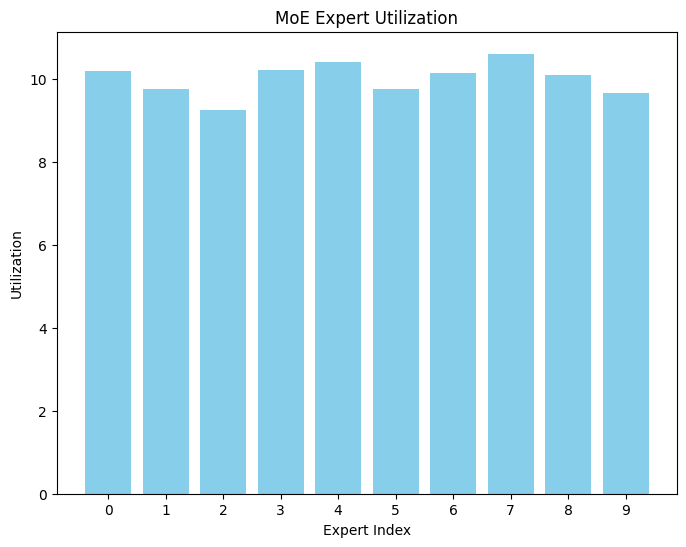

	Epoch 1 Validation: Loss = 0.5203, Accuracy = 0.7248, Recall = 0.9028


Epoch 2/30: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, accuracy=0.765, loss=0.509]

	Epoch 2 Training: Loss = 0.5094, Accuracy = 0.7646, Recall = 0.7959


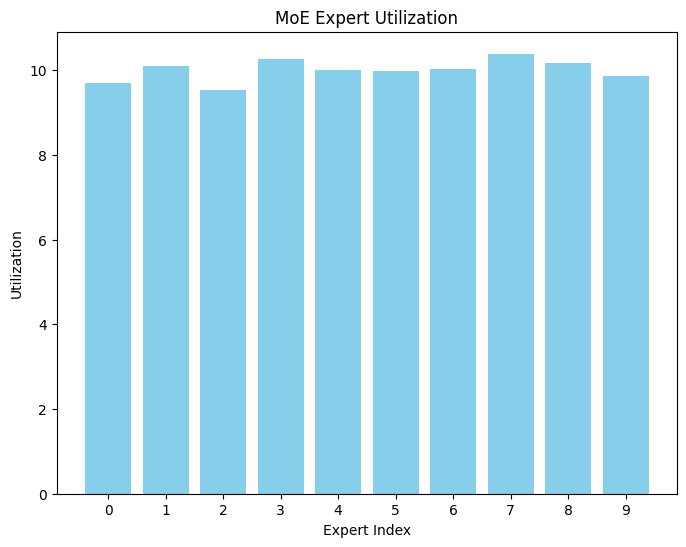

	Epoch 2 Validation: Loss = 0.4995, Accuracy = 0.7982, Recall = 0.7659


Epoch 3/30: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, accuracy=0.789, loss=0.478]

	Epoch 3 Training: Loss = 0.4778, Accuracy = 0.7894, Recall = 0.8213


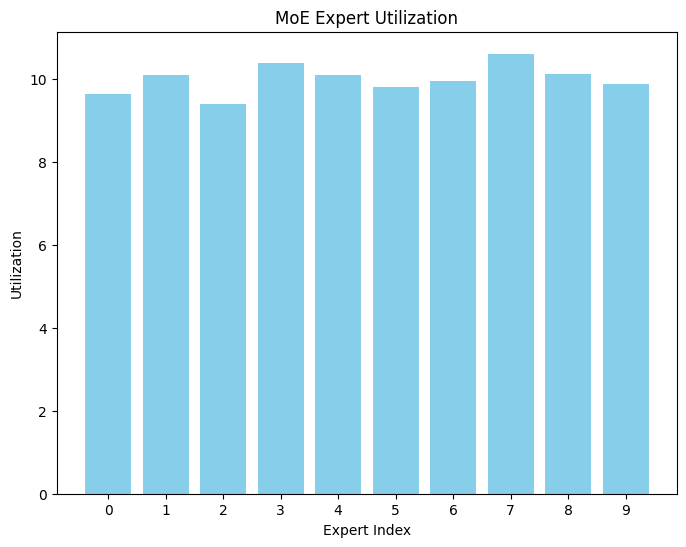

	Epoch 3 Validation: Loss = 0.4265, Accuracy = 0.8257, Recall = 0.7976


Epoch 4/30: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it, accuracy=0.827, loss=0.407]

	Epoch 4 Training: Loss = 0.4068, Accuracy = 0.8267, Recall = 0.8485


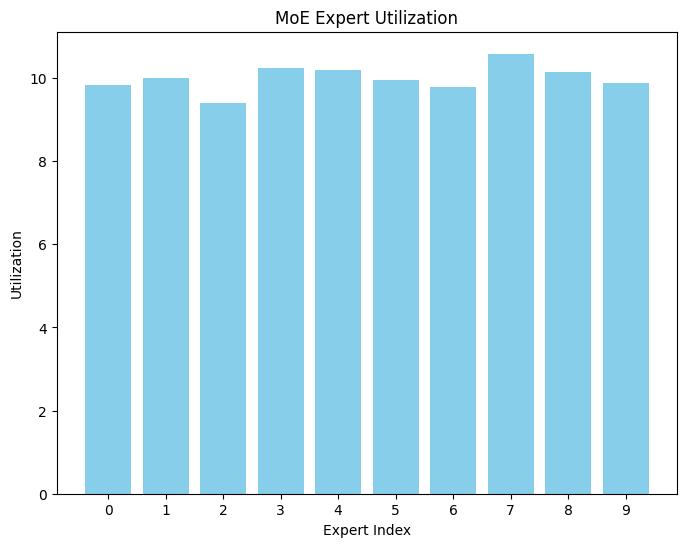

	Epoch 4 Validation: Loss = 0.4645, Accuracy = 0.7844, Recall = 0.9028


Epoch 5/30: 100%|██████████| 68/68 [01:11<00:00,  1.06s/it, accuracy=0.829, loss=0.407]

	Epoch 5 Training: Loss = 0.4069, Accuracy = 0.8294, Recall = 0.8587


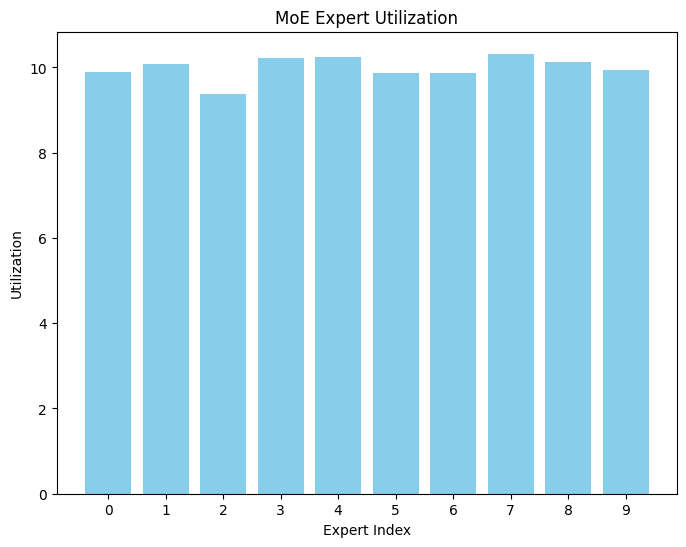

	Epoch 5 Validation: Loss = 0.3805, Accuracy = 0.8440, Recall = 0.8730


Epoch 6/30: 100%|██████████| 68/68 [01:10<00:00,  1.03s/it, accuracy=0.835, loss=0.381]

	Epoch 6 Training: Loss = 0.3811, Accuracy = 0.8354, Recall = 0.8555


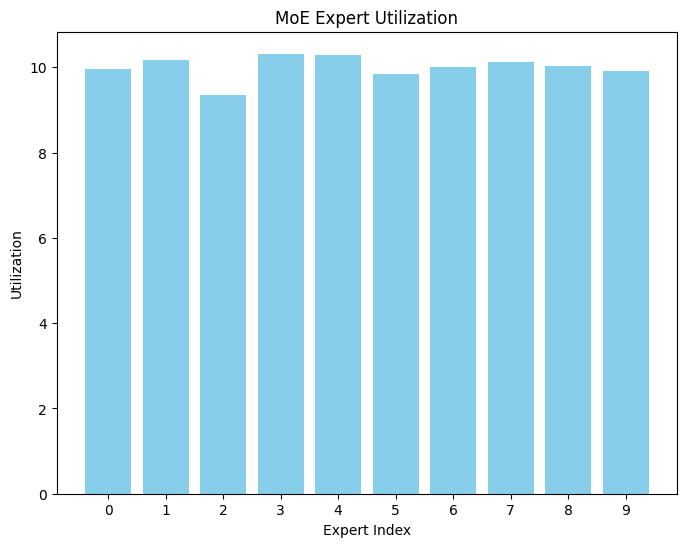

	Epoch 6 Validation: Loss = 0.3750, Accuracy = 0.8532, Recall = 0.8790


Epoch 7/30: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, accuracy=0.831, loss=0.383]

	Epoch 7 Training: Loss = 0.3832, Accuracy = 0.8308, Recall = 0.8531


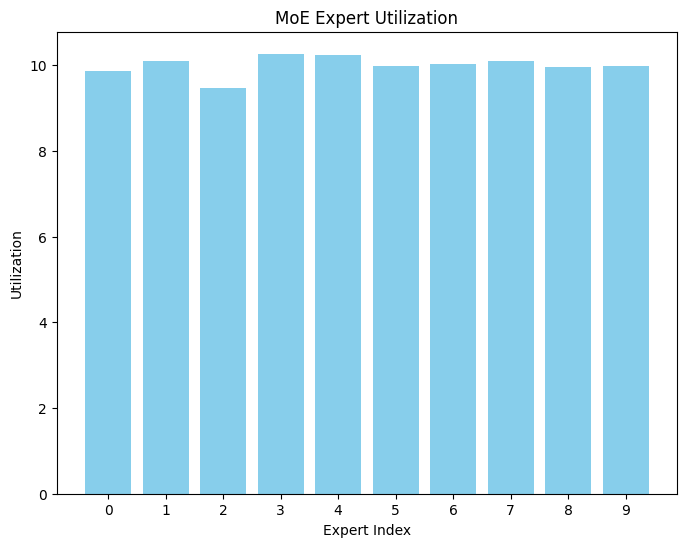

	Epoch 7 Validation: Loss = 0.3666, Accuracy = 0.7936, Recall = 0.5754


Epoch 8/30: 100%|██████████| 68/68 [01:19<00:00,  1.17s/it, accuracy=0.851, loss=0.351]

	Epoch 8 Training: Loss = 0.3511, Accuracy = 0.8506, Recall = 0.8654


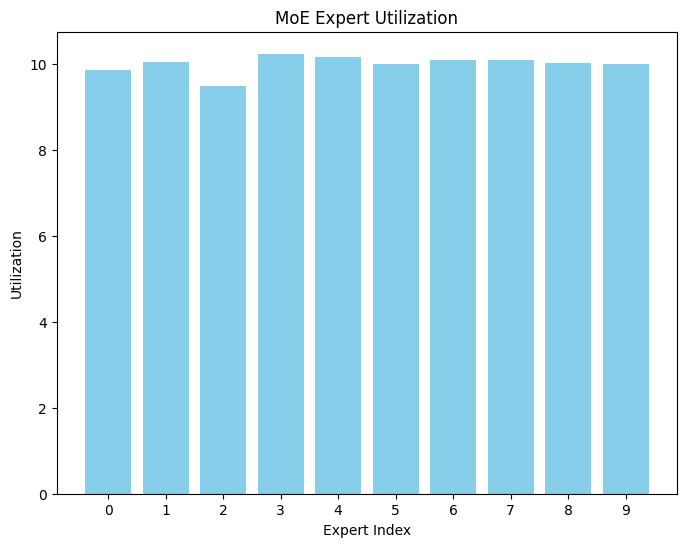

	Epoch 8 Validation: Loss = 0.3866, Accuracy = 0.8486, Recall = 0.7798


Epoch 9/30: 100%|██████████| 68/68 [01:19<00:00,  1.16s/it, accuracy=0.85, loss=0.359] 


	Epoch 9 Training: Loss = 0.3588, Accuracy = 0.8501, Recall = 0.8580


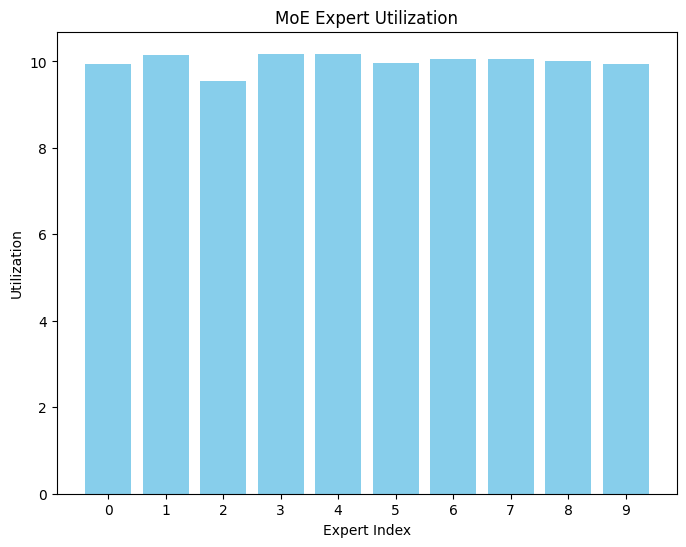

	Epoch 9 Validation: Loss = 0.3654, Accuracy = 0.8394, Recall = 0.8155


Epoch 10/30: 100%|██████████| 68/68 [01:17<00:00,  1.14s/it, accuracy=0.859, loss=0.334]

	Epoch 10 Training: Loss = 0.3340, Accuracy = 0.8593, Recall = 0.8711


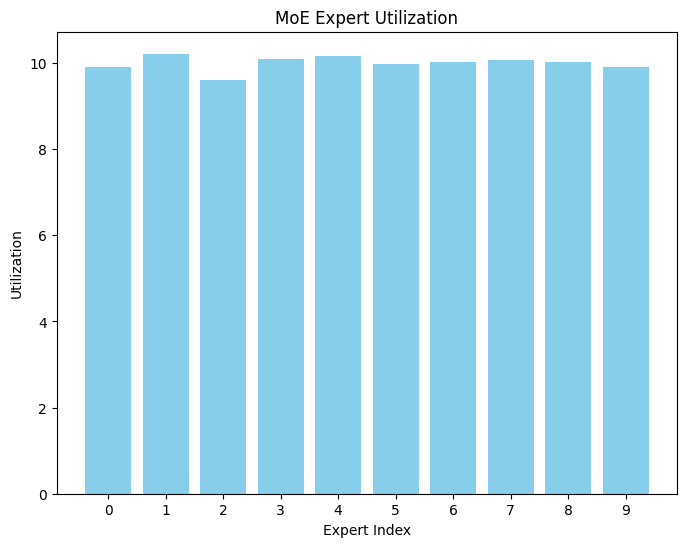

	Epoch 10 Validation: Loss = 0.3212, Accuracy = 0.8670, Recall = 0.7718


Epoch 11/30: 100%|██████████| 68/68 [01:22<00:00,  1.21s/it, accuracy=0.853, loss=0.36] 


	Epoch 11 Training: Loss = 0.3599, Accuracy = 0.8529, Recall = 0.8634


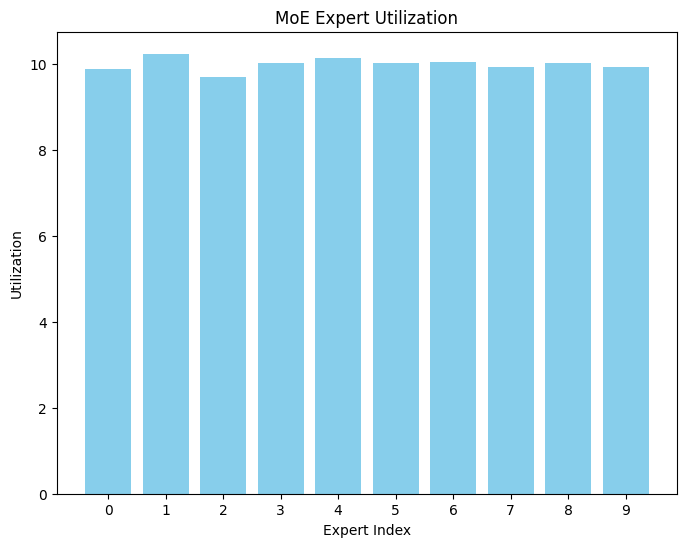

	Epoch 11 Validation: Loss = 0.3107, Accuracy = 0.8578, Recall = 0.7917


Epoch 12/30: 100%|██████████| 68/68 [01:19<00:00,  1.17s/it, accuracy=0.872, loss=0.305]

	Epoch 12 Training: Loss = 0.3045, Accuracy = 0.8722, Recall = 0.8869


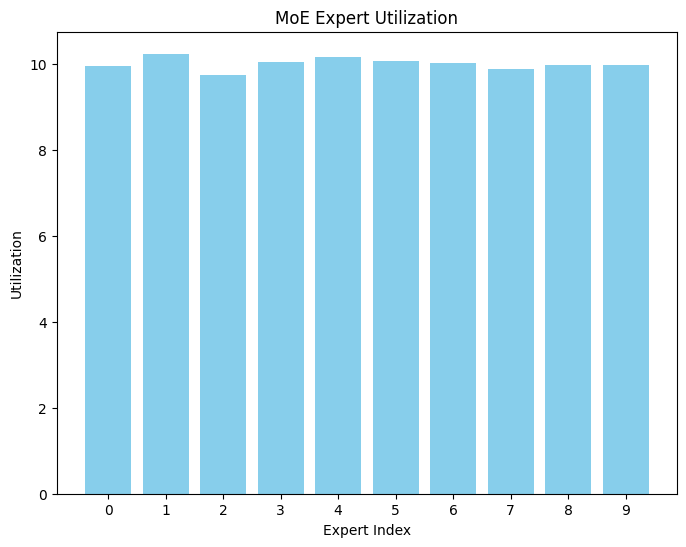

	Epoch 12 Validation: Loss = 0.3138, Accuracy = 0.8532, Recall = 0.8849


Epoch 13/30: 100%|██████████| 68/68 [01:16<00:00,  1.12s/it, accuracy=0.88, loss=0.295] 

	Epoch 13 Training: Loss = 0.2950, Accuracy = 0.8800, Recall = 0.9032


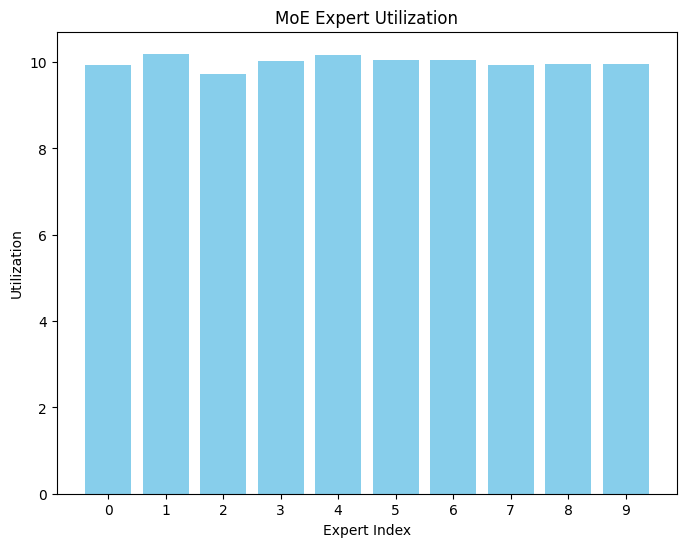

	Epoch 13 Validation: Loss = 0.3985, Accuracy = 0.8165, Recall = 0.8036


Epoch 14/30: 100%|██████████| 68/68 [01:10<00:00,  1.04s/it, accuracy=0.881, loss=0.289]

	Epoch 14 Training: Loss = 0.2890, Accuracy = 0.8809, Recall = 0.8923


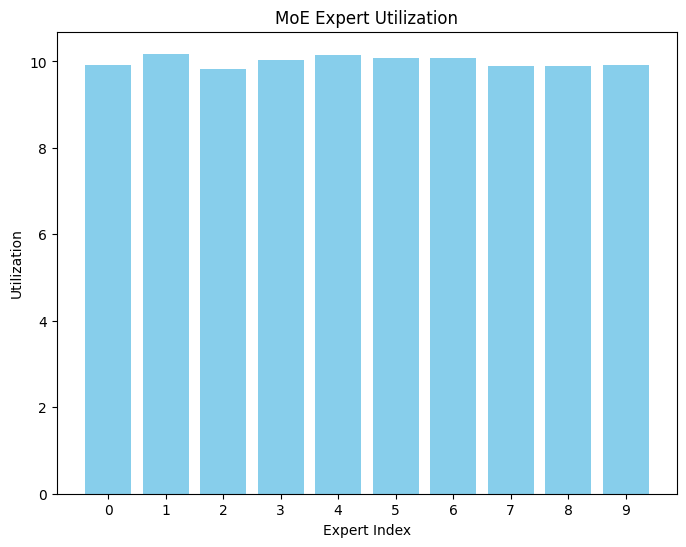

	Epoch 14 Validation: Loss = 0.3701, Accuracy = 0.8119, Recall = 0.8313


Epoch 15/30: 100%|██████████| 68/68 [01:10<00:00,  1.03s/it, accuracy=0.879, loss=0.3]  

	Epoch 15 Training: Loss = 0.3000, Accuracy = 0.8791, Recall = 0.8875


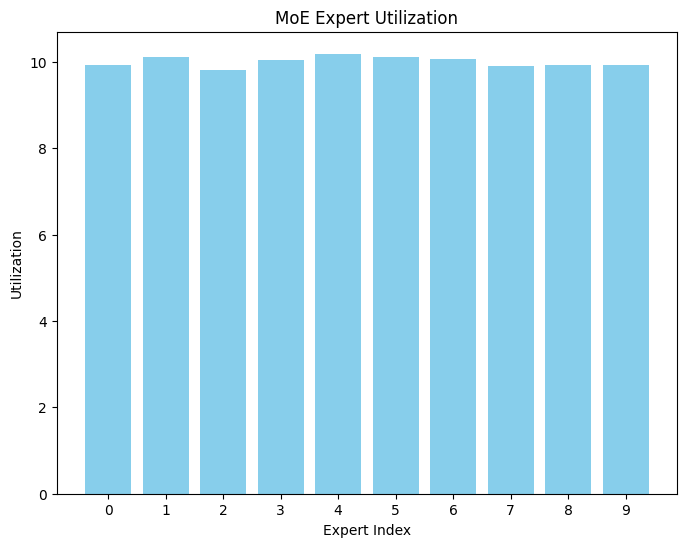

	Epoch 15 Validation: Loss = 0.4134, Accuracy = 0.8716, Recall = 0.7500


Epoch 16/30: 100%|██████████| 68/68 [01:09<00:00,  1.02s/it, accuracy=0.875, loss=0.3]  

	Epoch 16 Training: Loss = 0.3003, Accuracy = 0.8749, Recall = 0.8828


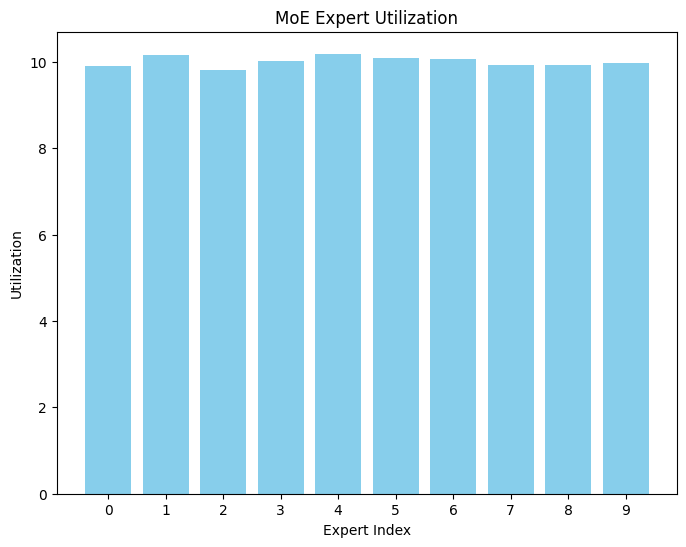

	Epoch 16 Validation: Loss = 0.3225, Accuracy = 0.8716, Recall = 0.7758


Epoch 17/30: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it, accuracy=0.891, loss=0.276]

	Epoch 17 Training: Loss = 0.2765, Accuracy = 0.8915, Recall = 0.9077


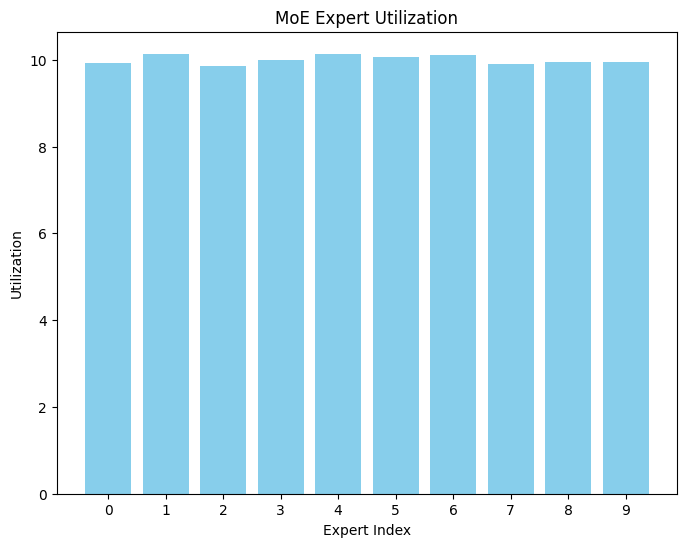

	Epoch 17 Validation: Loss = 0.3946, Accuracy = 0.8211, Recall = 0.8552


Epoch 18/30: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, accuracy=0.901, loss=0.242]

	Epoch 18 Training: Loss = 0.2420, Accuracy = 0.9011, Recall = 0.9116


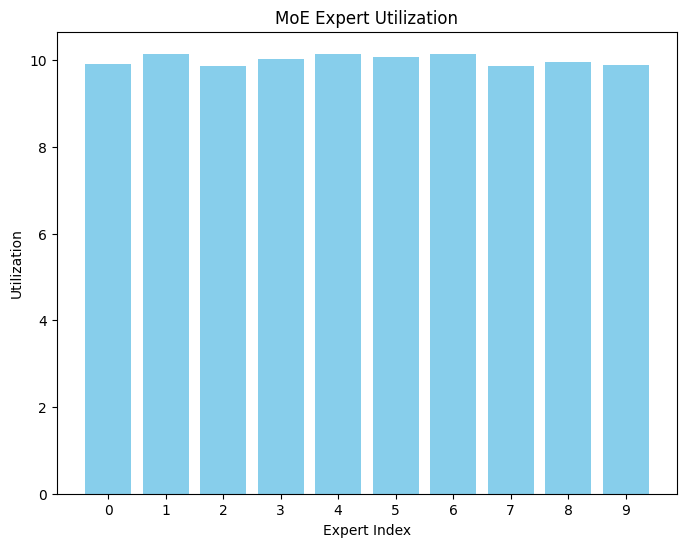

	Epoch 18 Validation: Loss = 0.3069, Accuracy = 0.8624, Recall = 0.7639


Epoch 19/30: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, accuracy=0.886, loss=0.279]

	Epoch 19 Training: Loss = 0.2792, Accuracy = 0.8864, Recall = 0.9105


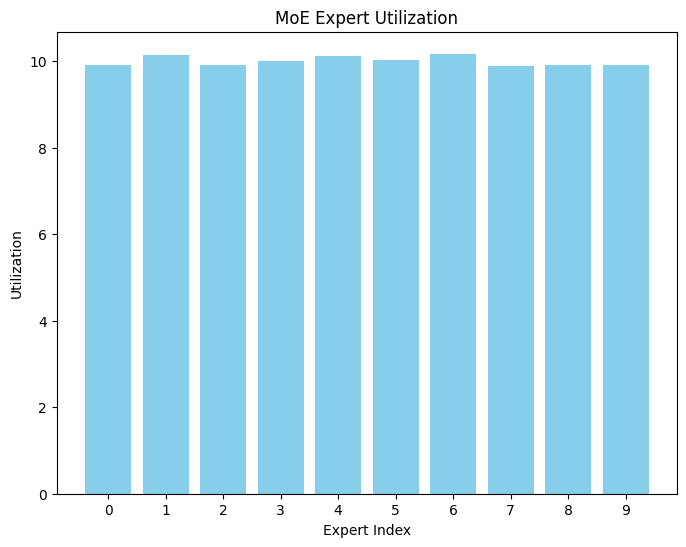

	Epoch 19 Validation: Loss = 0.3386, Accuracy = 0.8670, Recall = 0.7897


Epoch 20/30: 100%|██████████| 68/68 [01:16<00:00,  1.13s/it, accuracy=0.894, loss=0.268]

	Epoch 20 Training: Loss = 0.2683, Accuracy = 0.8938, Recall = 0.9029


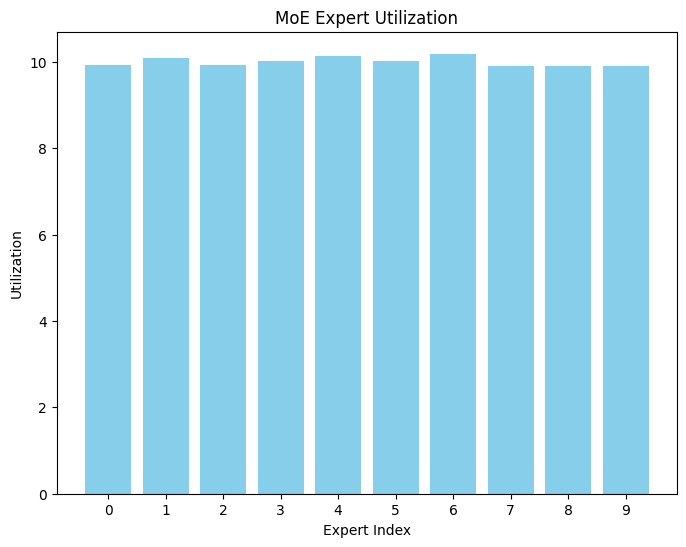

	Epoch 20 Validation: Loss = 0.3091, Accuracy = 0.8716, Recall = 0.7877


Epoch 21/30: 100%|██████████| 68/68 [01:11<00:00,  1.05s/it, accuracy=0.897, loss=0.249]

	Epoch 21 Training: Loss = 0.2488, Accuracy = 0.8975, Recall = 0.9108


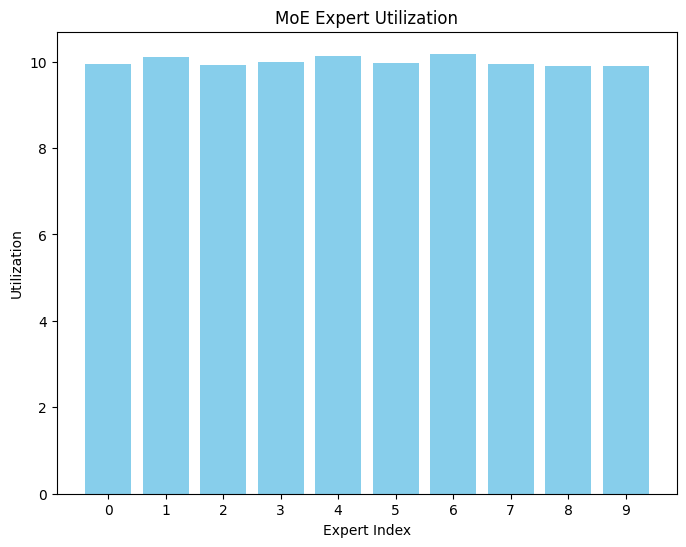

	Epoch 21 Validation: Loss = 0.3005, Accuracy = 0.8670, Recall = 0.9226


Epoch 22/30: 100%|██████████| 68/68 [01:12<00:00,  1.07s/it, accuracy=0.907, loss=0.24] 

	Epoch 22 Training: Loss = 0.2398, Accuracy = 0.9071, Recall = 0.9171


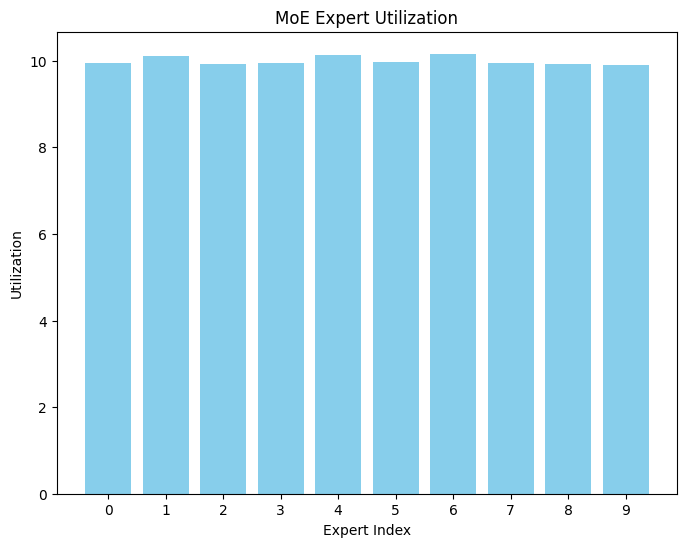

	Epoch 22 Validation: Loss = 0.4305, Accuracy = 0.7936, Recall = 0.8730


Epoch 23/30: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, accuracy=0.907, loss=0.242]

	Epoch 23 Training: Loss = 0.2423, Accuracy = 0.9067, Recall = 0.9209


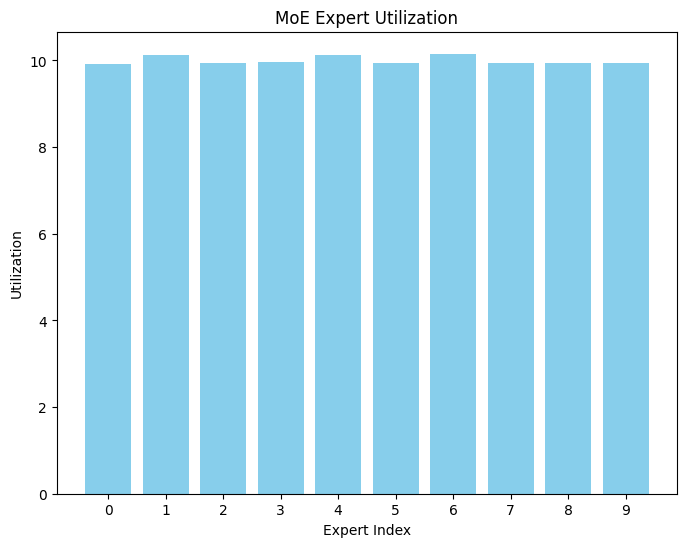

	Epoch 23 Validation: Loss = 0.3944, Accuracy = 0.8073, Recall = 0.9048


Epoch 24/30: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it, accuracy=0.907, loss=0.259]

	Epoch 24 Training: Loss = 0.2590, Accuracy = 0.9067, Recall = 0.9077


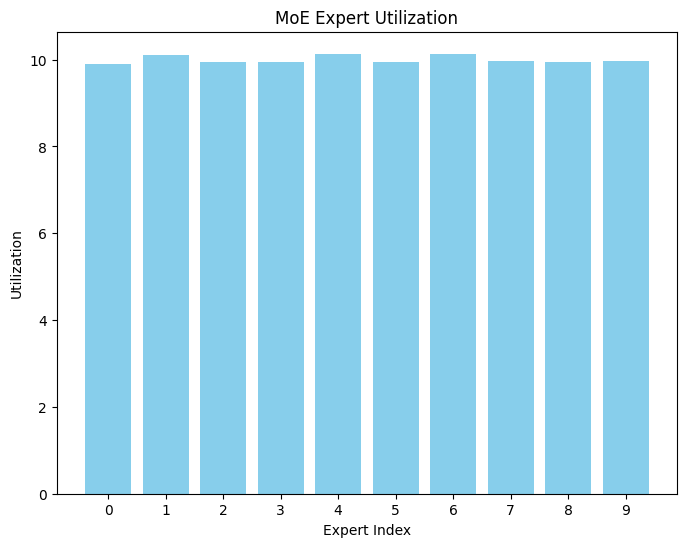

	Epoch 24 Validation: Loss = 0.2759, Accuracy = 0.8761, Recall = 0.8750


Epoch 25/30: 100%|██████████| 68/68 [01:14<00:00,  1.09s/it, accuracy=0.921, loss=0.22] 

	Epoch 25 Training: Loss = 0.2201, Accuracy = 0.9209, Recall = 0.9323


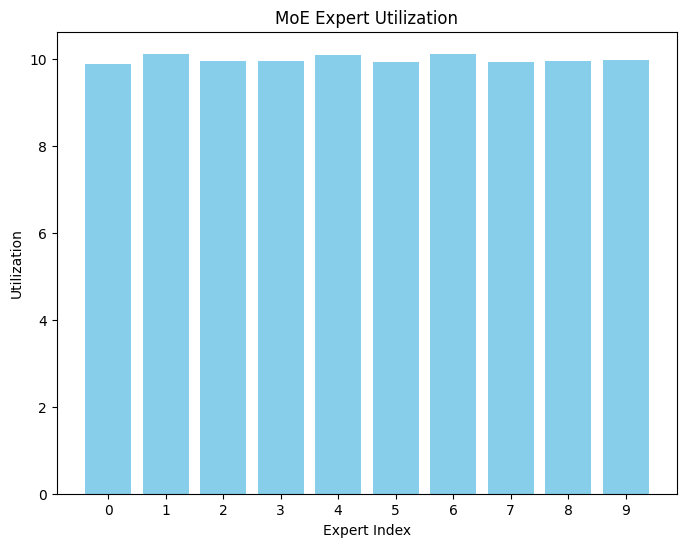

	Epoch 25 Validation: Loss = 0.2538, Accuracy = 0.8807, Recall = 0.8512


Epoch 26/30: 100%|██████████| 68/68 [01:16<00:00,  1.13s/it, accuracy=0.909, loss=0.234]

	Epoch 26 Training: Loss = 0.2339, Accuracy = 0.9085, Recall = 0.9189


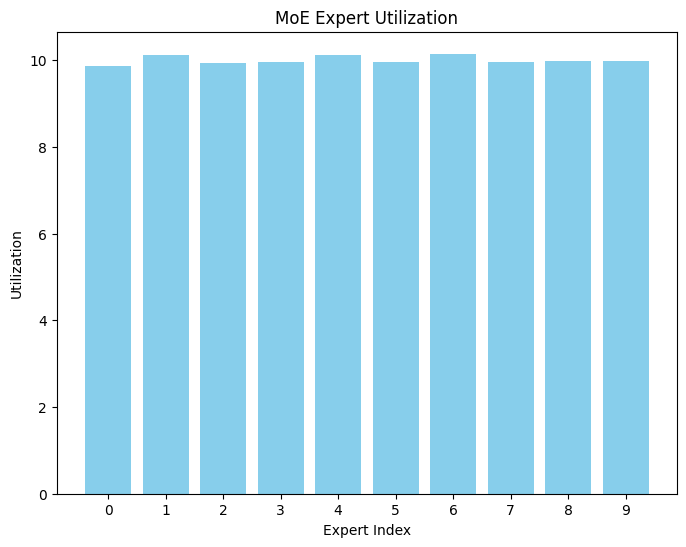

	Epoch 26 Validation: Loss = 0.3135, Accuracy = 0.8670, Recall = 0.6766


Epoch 27/30: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it, accuracy=0.91, loss=0.216] 

	Epoch 27 Training: Loss = 0.2159, Accuracy = 0.9103, Recall = 0.9231


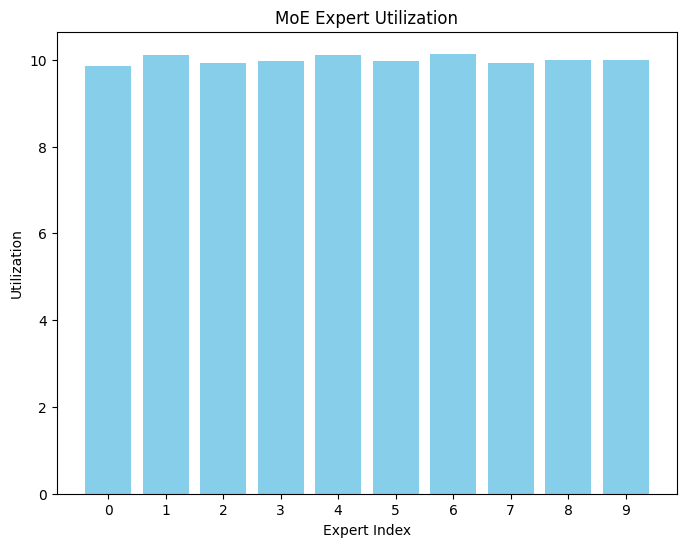

	Epoch 27 Validation: Loss = 0.2757, Accuracy = 0.8899, Recall = 0.8889


Epoch 28/30: 100%|██████████| 68/68 [01:13<00:00,  1.08s/it, accuracy=0.925, loss=0.198]

	Epoch 28 Training: Loss = 0.1978, Accuracy = 0.9246, Recall = 0.9459


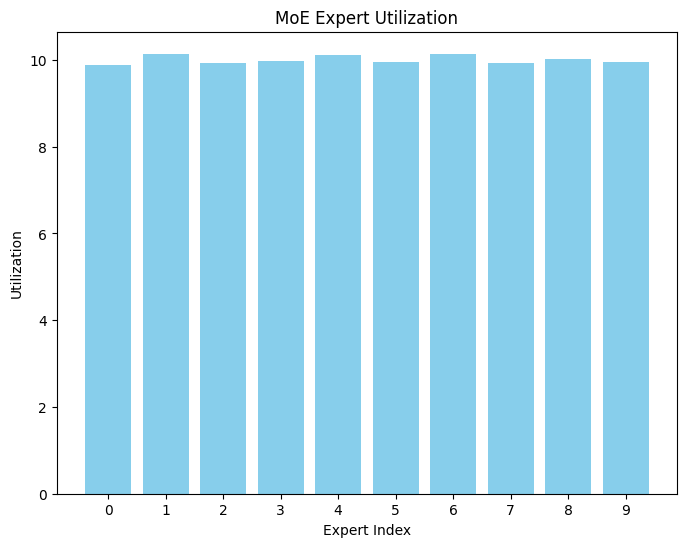

	Epoch 28 Validation: Loss = 0.3075, Accuracy = 0.8716, Recall = 0.7659


Epoch 29/30: 100%|██████████| 68/68 [01:18<00:00,  1.15s/it, accuracy=0.917, loss=0.21] 

	Epoch 29 Training: Loss = 0.2101, Accuracy = 0.9168, Recall = 0.9220


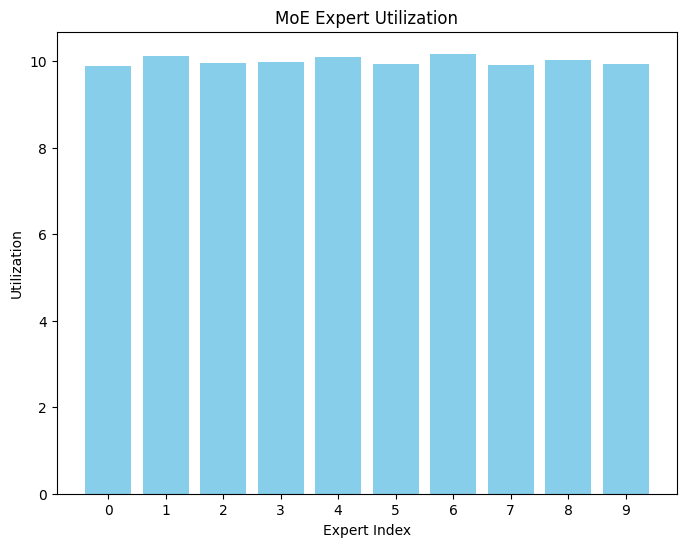

	Epoch 29 Validation: Loss = 0.3165, Accuracy = 0.8761, Recall = 0.7599


Epoch 30/30: 100%|██████████| 68/68 [01:15<00:00,  1.12s/it, accuracy=0.92, loss=0.212] 

	Epoch 30 Training: Loss = 0.2120, Accuracy = 0.9200, Recall = 0.9439


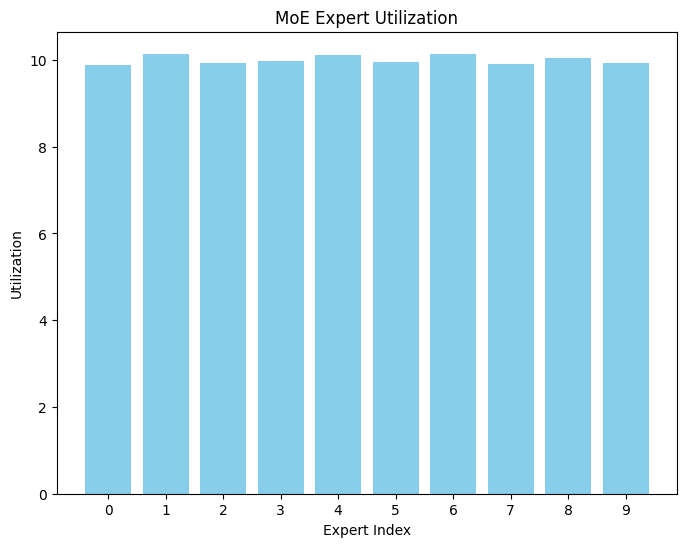

	Epoch 30 Validation: Loss = 0.3480, Accuracy = 0.8257, Recall = 0.9405
Training Complete!


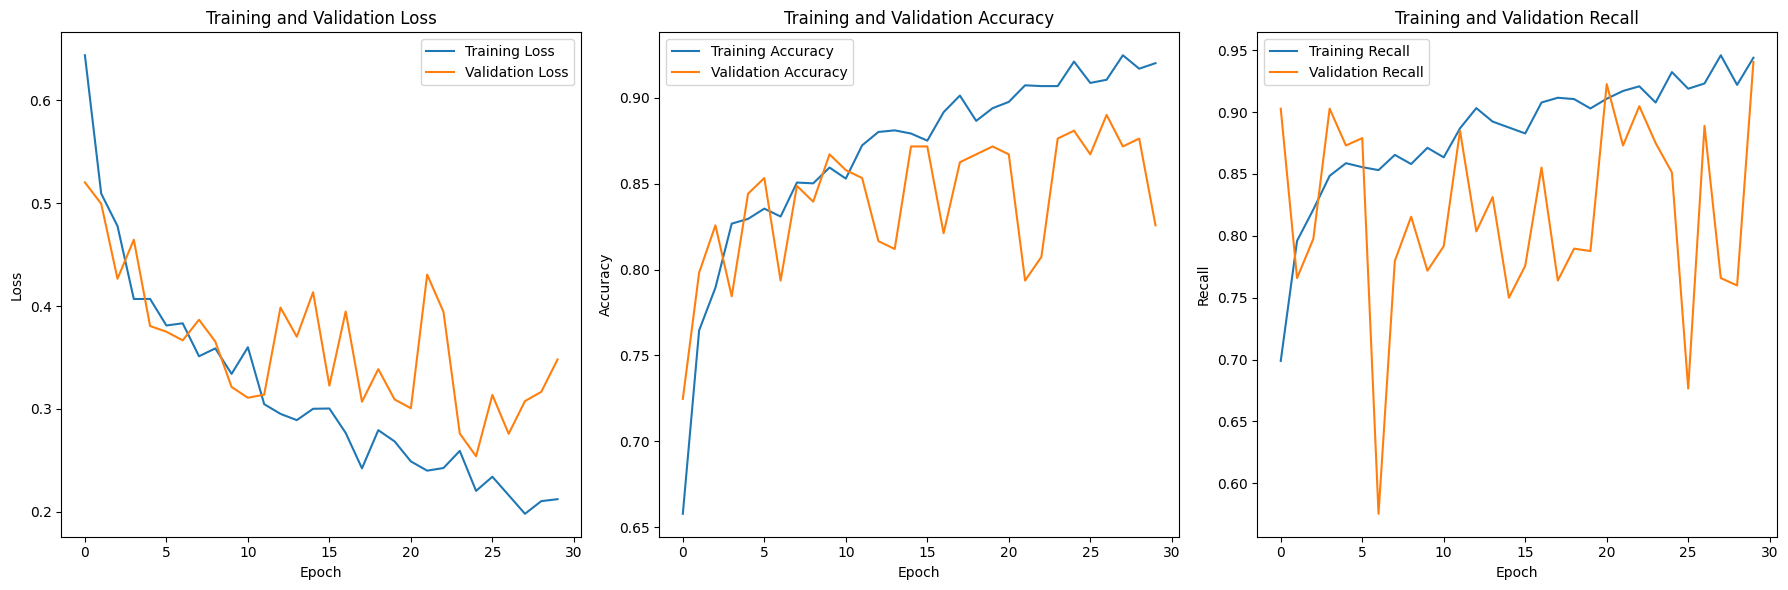

In [ ]:
class_hidden_dims = None
num_classes = 2
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)


enhancement_params={'num_experts': 10, 'output_dim': 64, 'top_k': 2, 'temperature':2, 'reduction':8}
model_moe = FeatureExtractorClassifier(
    backbone_encoder=backbone,
    num_classes=num_classes,
    enhancement_type='moe',
    enhancement_params=enhancement_params,
    class_hidden_dims=class_hidden_dims
)

print(count_parameters(model_moe))

criterion =  nn.CrossEntropyLoss()

model_moe.enhancement_block._initialize_parameters()
train(
    model=model_moe, 
    train_loader=train_loader_stain, 
    val_loader=val_loader_stain, 
    criterion=criterion, 
    epochs=30, 
    batch_size=batch_size, 
    base_lr=1e-4, 
    weight_decay=1e-4, 
    max_grad_norm=1.0, 
    save_path=None,
    use_scheduler=False,
    val_acc_threshold=1,
    val_rec_threshold=1
)

Given that in such tasks we usually prefer high recall models, we see below a resonable performance on the both datasets, stain and no-stain. We also see a nice expert utilization. The performance on the no-stain dataset shows us that our model can generalize to diffent color and brightness artifacts.

Test Accuracy: 81.37%
Test Recall: 92.50%


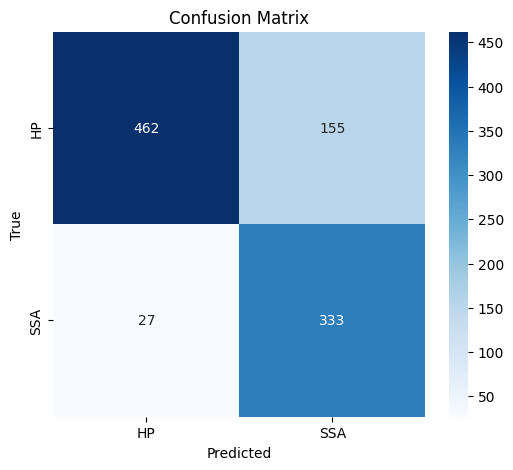

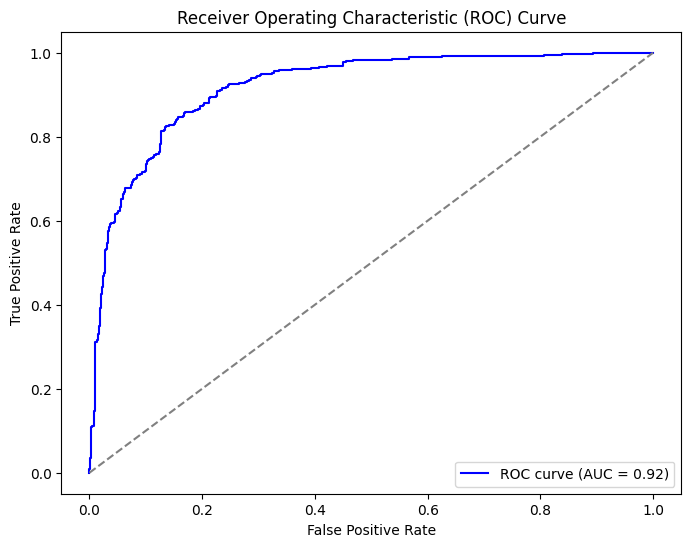

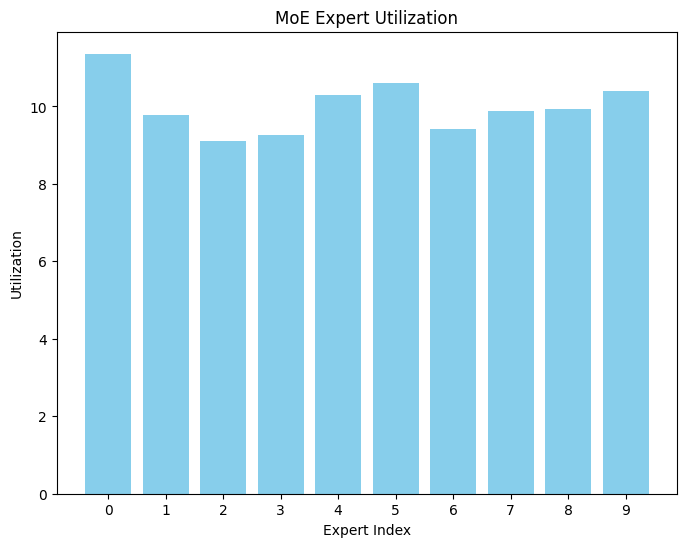

In [ ]:
test_roc(model_moe.to(device),test_loader_stain,device=device, show_expert_util=True);

Test Accuracy: 80.25%
Test Recall: 87.50%


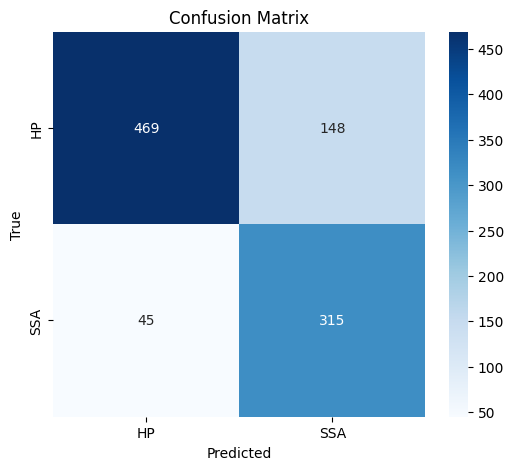

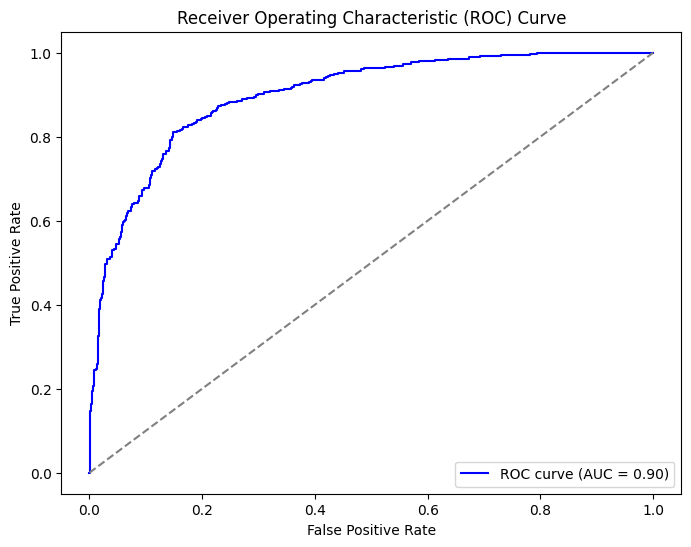

In [59]:
test_roc(model_moe.to(device),test_loader_nostain,device=device, show_expert_util=True);

Here we plot the embeddings of the expert outputs. We can see that the experts produce reasonable embeddings to be passed as inputs to the classifier.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def analyze_moe_outputs_with_pca(model, test_dataloader, n_components=2):
    """
    Perform PCA on the outputs of the MoEBlock in the FeatureExtractorClassifier model.
    
    Args:
        model (nn.Module): FeatureExtractorClassifier with MoEBlock (accessible as model.enhancement_block).
        test_dataloader (DataLoader): DataLoader for the test dataset.
        n_components (int): Number of principal components for PCA.
        
    Returns:
        pca_transformed_features (np.ndarray): PCA-transformed features of MoEBlock outputs.
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # To store outputs from MoEBlock
    moe_outputs = []
    labels = []

    
    with torch.no_grad():
        for batch in test_dataloader:
            # Assuming the dataloader returns (inputs, labels)
            inputs, batch_labels = batch
            inputs = inputs.to(next(model.parameters()).device)
            
            # Forward pass through feature extractor and enhancement block
            x = model.extractor(inputs)
            if model.enhancement_block:
                x = model.enhancement_block(x)
                moe_outputs.append(x.cpu().numpy())
                labels.extend(batch_labels.cpu().numpy())

    
    # Stack all outputs into a single array
    moe_outputs = np.concatenate(moe_outputs, axis=0)  # Shape: [N, C, H, W]
    labels = np.array(labels)  # Shape: [N]

    
    # Flatten the spatial dimensions for PCA
    N, C, H, W = moe_outputs.shape
    flattened_features = moe_outputs.reshape(N, -1)  # Shape: [N, C*H*W]
    print(f'{flattened_features.shape}')
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_transformed_features = pca.fit_transform(flattened_features)  # Shape: [N, n_components]
    
    # t-SNE
    tsne = TSNE(n_components=n_components, random_state=42)
    tsne_transformed = tsne.fit_transform(pca_transformed_features)
    
    # Visualization Function
    def plot_embedding(embedding, labels, title):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', alpha=0.7
        )
        plt.colorbar(scatter, label='Class Labels')
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()
    
    # Visualize PCA
    plot_embedding(pca_transformed_features, labels, "PCA of MoE Outputs")
    plot_embedding(tsne_transformed, labels, "tSNE of MoE Outputs")

    
    return pca_transformed_features



(2175, 3136)


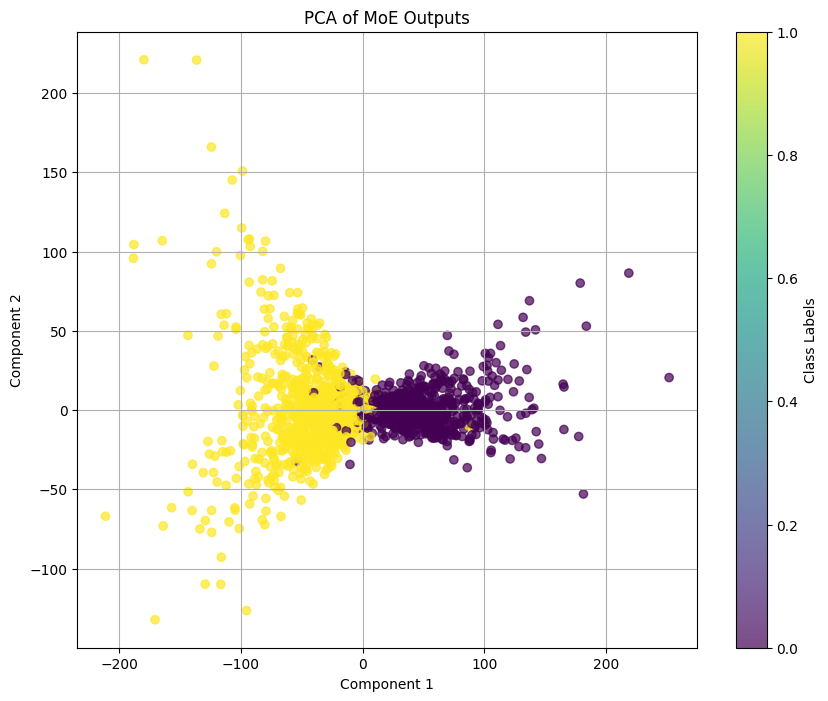

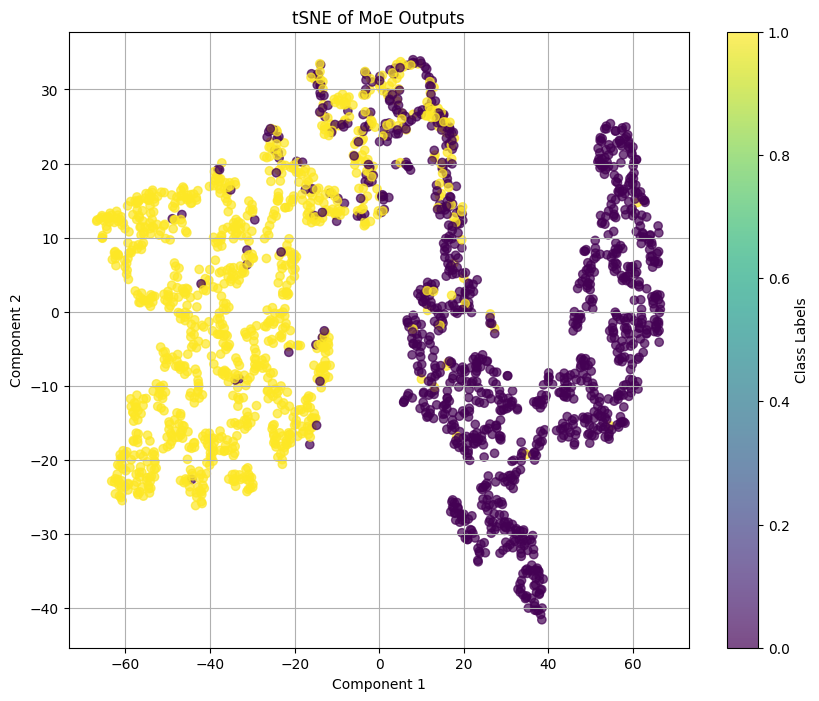

In [81]:
analyze_moe_outputs_with_pca(model_moe,train_loader_stain);

(977, 3136)


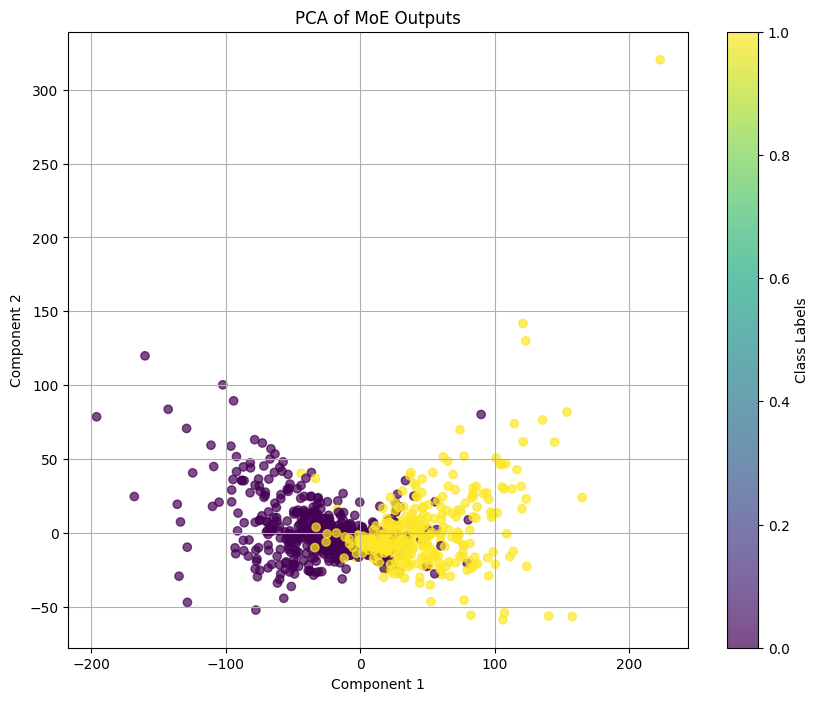

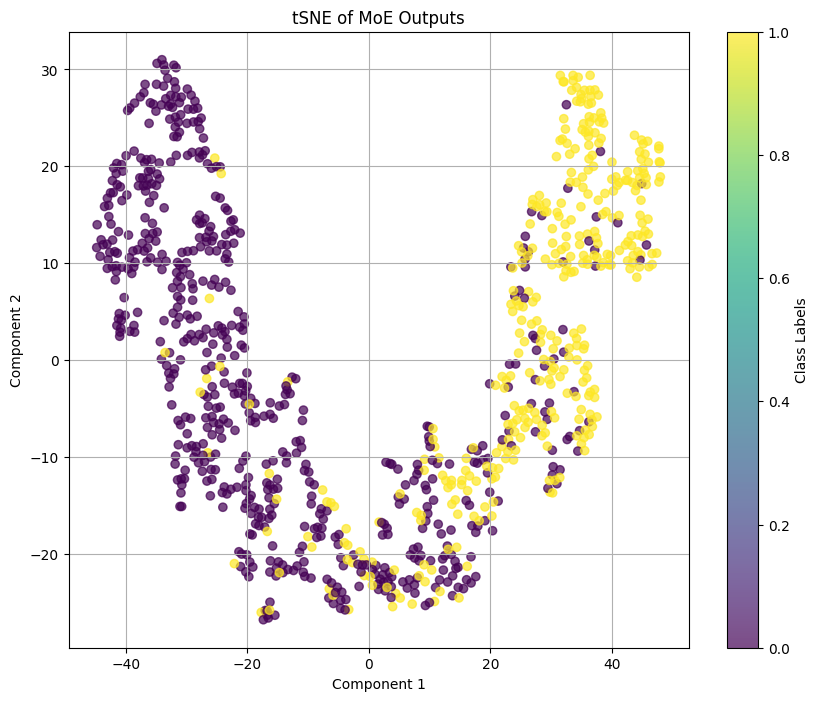

In [69]:
analyze_moe_outputs_with_pca(model_moe,test_loader_stain);

(977, 3136)


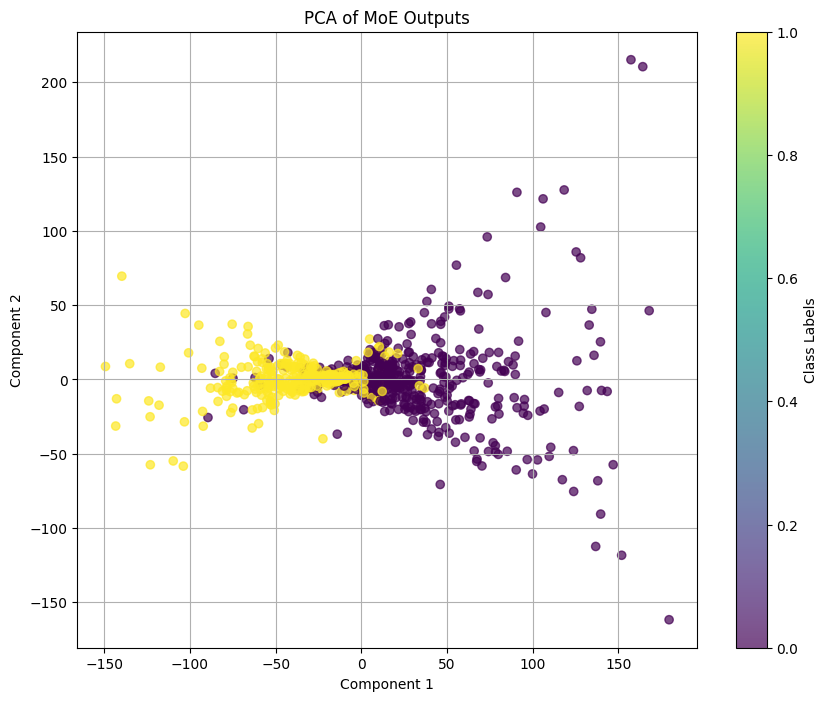

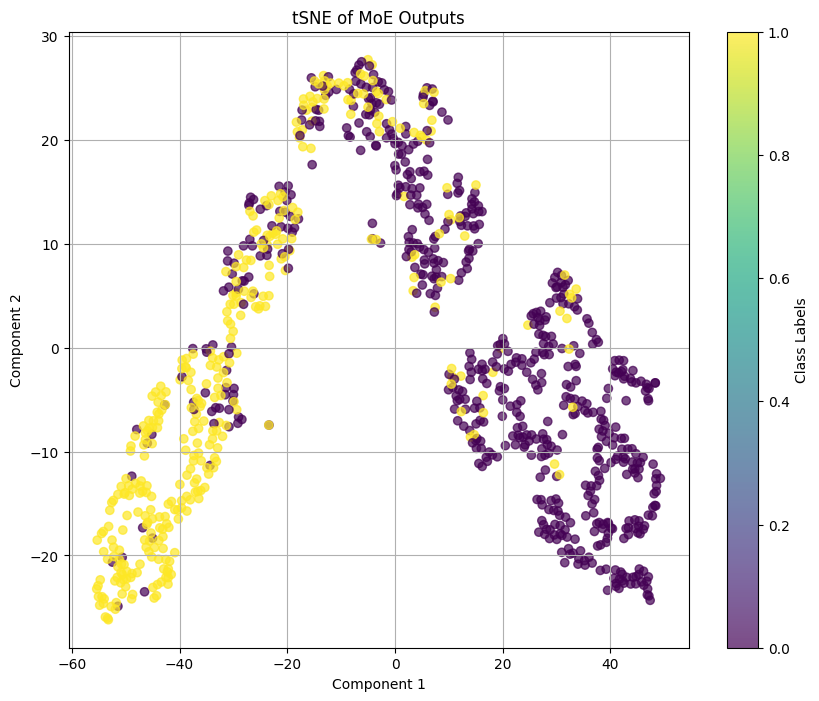

In [70]:
analyze_moe_outputs_with_pca(model_moe,test_loader_nostain);

Here we explain some of the instance predictions using the Integrated Gradients method from Captum

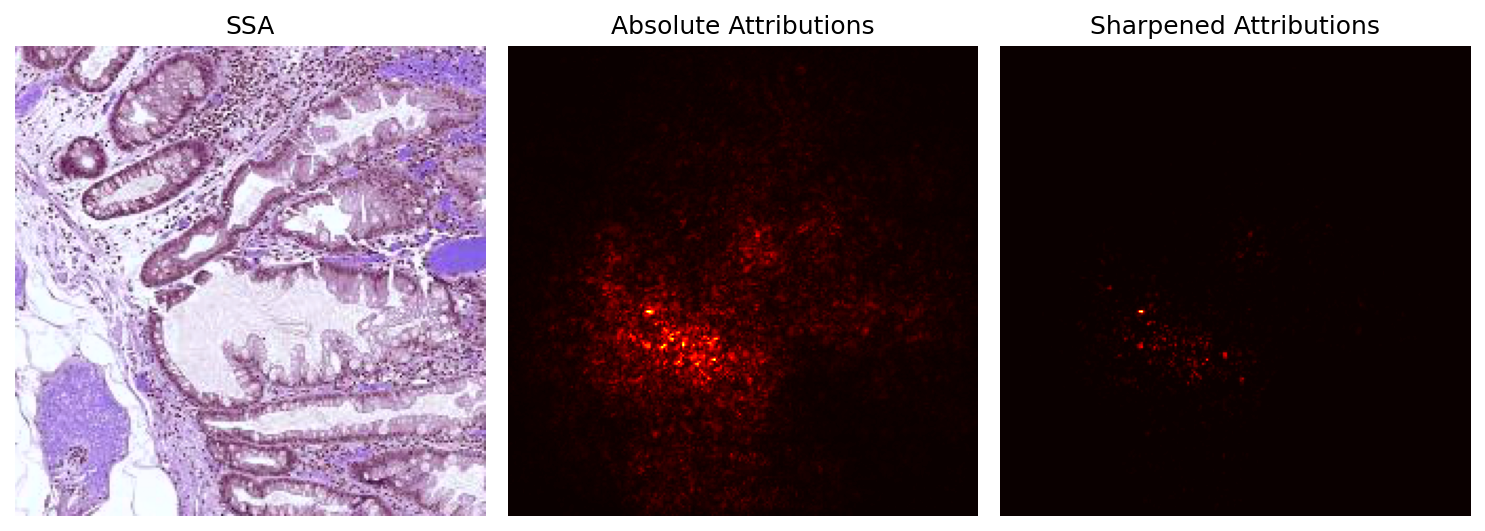

In [64]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import random

model_moe.eval().to(torch.float32).cpu()

random_idx = random.randint(0, len(test_dataset_stain) - 1)
random_idx = 865
# Get the image and label corresponding to the random index
image_to_explore, label_to_explore = test_dataset_stain[random_idx]  # Sample random image and label
image_to_explore = image_to_explore.unsqueeze(0).to(torch.float32)  # Add batch dimension (1, C, H, W) if needed
image_np = image_to_explore.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Initialize Integrated Gradients
ig = IntegratedGradients(model_moe)

# Compute the attributions
attributions, delta = ig.attribute(image_to_explore, target=label_to_explore, return_convergence_delta=True)

# Convert attributions to NumPy
attributions = attributions.squeeze(0).cpu().detach().numpy()

# Sharpen the attributions by squaring
attributions_sharpened = attributions ** 2  # Element-wise squaring

# Normalize the sharpened attributions for display
attributions_sharpened_norm = (attributions_sharpened[0] - attributions_sharpened[0].min()) / \
                              (attributions_sharpened[0].max() - attributions_sharpened[0].min())

attributions_sum = np.sum(np.abs(attributions), axis=0)


# Plot the original image and sharpened attributions side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=150)  # Increase dpi to improve resolution

label_map = {1: 'SSA', 0: 'HP'}

# Original image
axes[0].imshow(image_np)
axes[0].set_title(f"{label_map[label_to_explore]}")
axes[0].axis("off")

# Sharpened attribution map
axes[1].imshow(attributions_sum, cmap='hot')  # Normalized sharpened attribution map
axes[1].set_title(f"Absolute Attributions")
axes[1].axis("off")

# Absolute attribution map
axes[2].imshow(attributions_sharpened_norm, cmap='hot')  # Normalized sharpened attribution map
axes[2].set_title(f"Sharpened Attributions")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Below we see the same process but for the dataset that is not normalized and stained. While it has good performance on the training data, the model catastrophically breaks on the RandStainNA dataset. This validates our hypothesis regarding the generalization we gain with randomly normalizing and staining our slides. Also, the expert utilization seems to be worse, potentially because two experts focus a lot on the class label given the absence of stain normalization and augmentation variations (i.e., one expert for each class). 

Dimensions of feature map: 512
11814348


Epoch 1/30: 100%|██████████| 68/68 [00:51<00:00,  1.31it/s, accuracy=0.719, loss=0.564]

	Epoch 1 Training: Loss = 0.5645, Accuracy = 0.7191, Recall = 0.7173


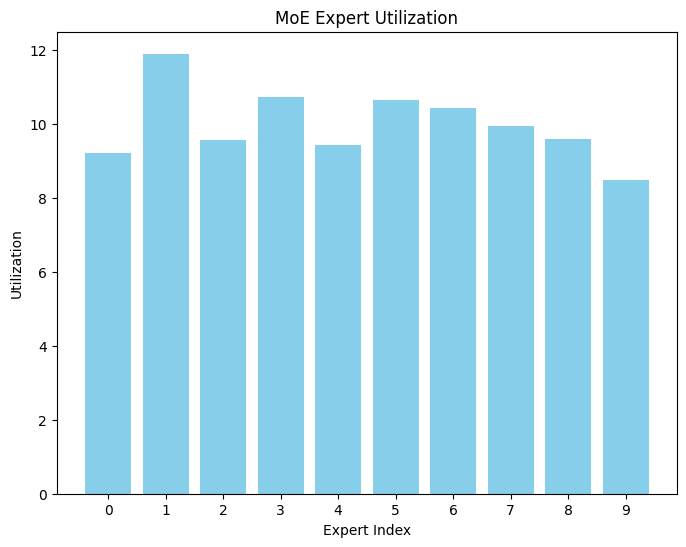

	Epoch 1 Validation: Loss = 0.4259, Accuracy = 0.8303, Recall = 0.4683


Epoch 2/30: 100%|██████████| 68/68 [00:51<00:00,  1.33it/s, accuracy=0.821, loss=0.425]

	Epoch 2 Training: Loss = 0.4252, Accuracy = 0.8207, Recall = 0.8178


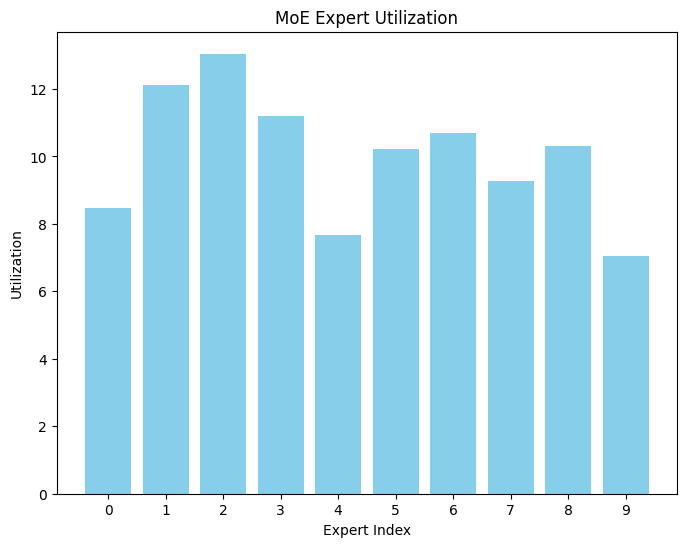

	Epoch 2 Validation: Loss = 0.4058, Accuracy = 0.8165, Recall = 0.7520


Epoch 3/30: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s, accuracy=0.835, loss=0.379]

	Epoch 3 Training: Loss = 0.3793, Accuracy = 0.8349, Recall = 0.8495


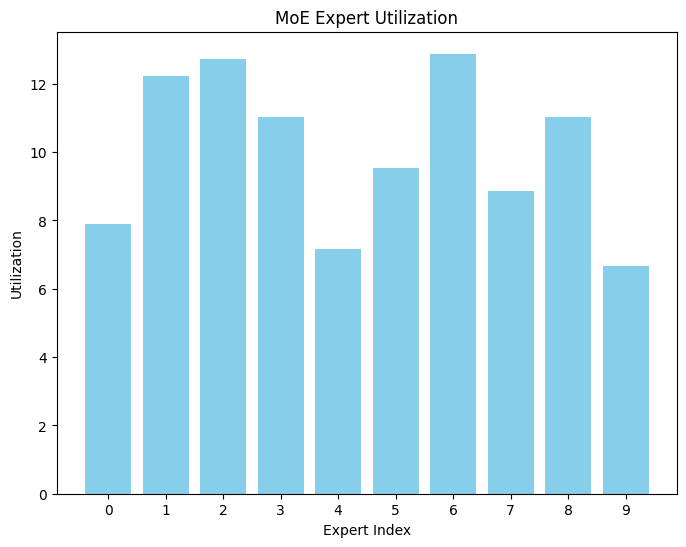

	Epoch 3 Validation: Loss = 0.4039, Accuracy = 0.8211, Recall = 0.8254


Epoch 4/30: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s, accuracy=0.848, loss=0.363]

	Epoch 4 Training: Loss = 0.3634, Accuracy = 0.8483, Recall = 0.8676


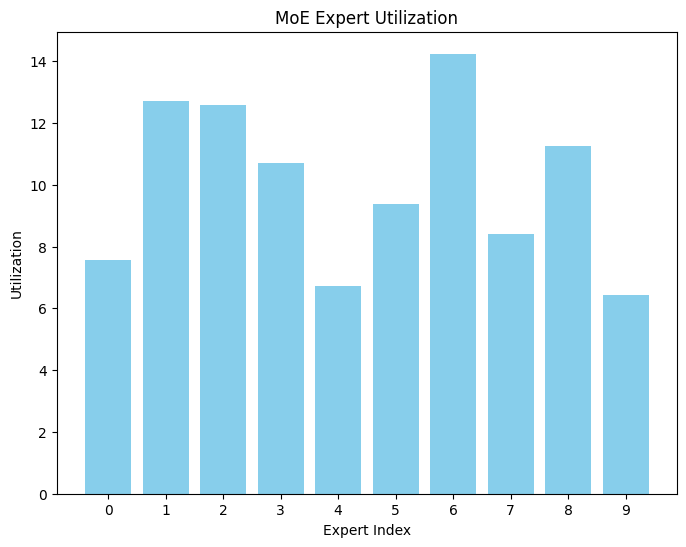

	Epoch 4 Validation: Loss = 0.3378, Accuracy = 0.8716, Recall = 0.7302


Epoch 5/30: 100%|██████████| 68/68 [00:54<00:00,  1.26it/s, accuracy=0.851, loss=0.357]

	Epoch 5 Training: Loss = 0.3572, Accuracy = 0.8515, Recall = 0.8613


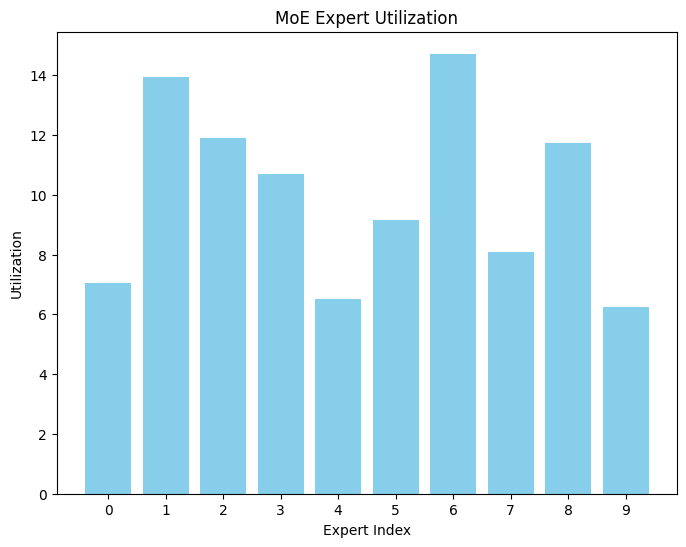

	Epoch 5 Validation: Loss = 0.3366, Accuracy = 0.8486, Recall = 0.7917


Epoch 6/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.868, loss=0.326]

	Epoch 6 Training: Loss = 0.3256, Accuracy = 0.8676, Recall = 0.8928


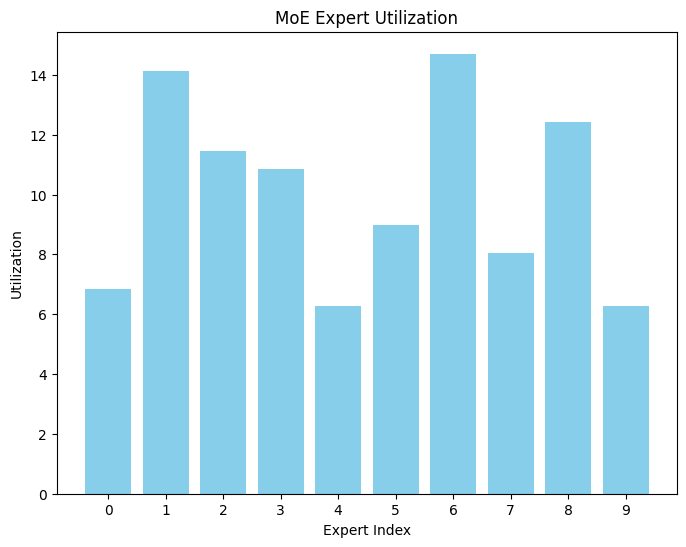

	Epoch 6 Validation: Loss = 0.3749, Accuracy = 0.8394, Recall = 0.8710


Epoch 7/30: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s, accuracy=0.868, loss=0.32] 

	Epoch 7 Training: Loss = 0.3199, Accuracy = 0.8676, Recall = 0.8807


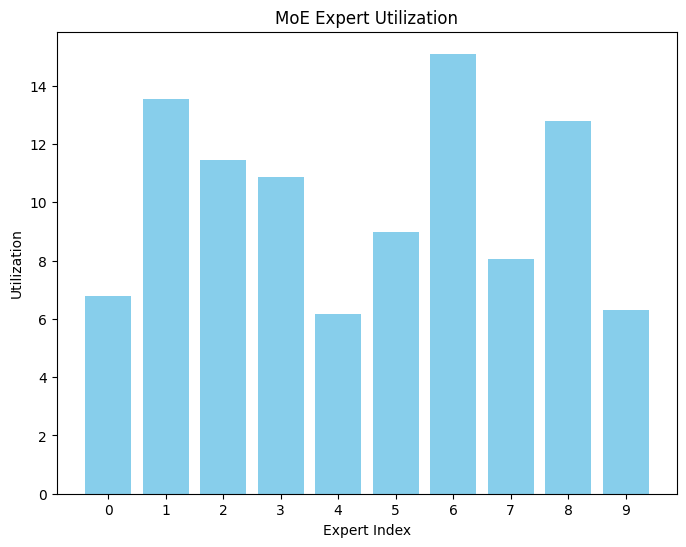

	Epoch 7 Validation: Loss = 0.3212, Accuracy = 0.8761, Recall = 0.6389


Epoch 8/30: 100%|██████████| 68/68 [00:54<00:00,  1.24it/s, accuracy=0.879, loss=0.29] 

	Epoch 8 Training: Loss = 0.2896, Accuracy = 0.8786, Recall = 0.8913


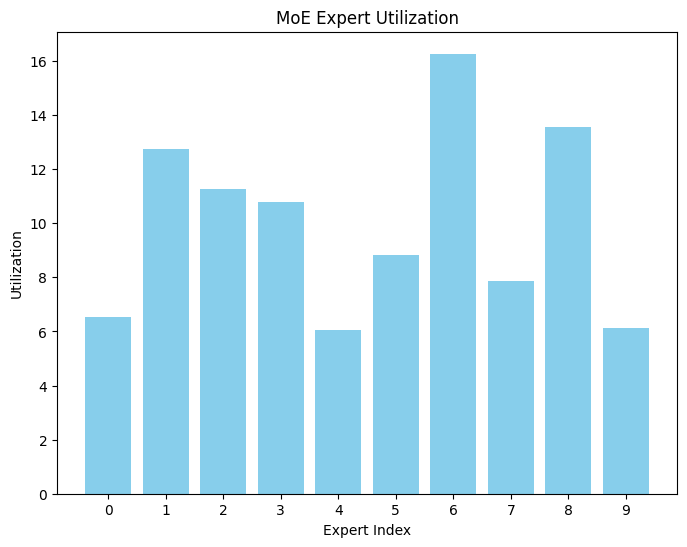

	Epoch 8 Validation: Loss = 0.2863, Accuracy = 0.8945, Recall = 0.7877


Epoch 9/30: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s, accuracy=0.888, loss=0.283]

	Epoch 9 Training: Loss = 0.2831, Accuracy = 0.8878, Recall = 0.8878


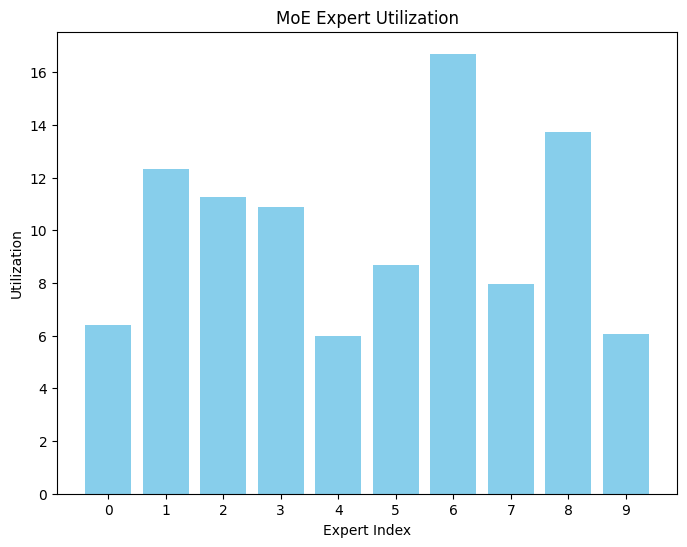

	Epoch 9 Validation: Loss = 0.2954, Accuracy = 0.8991, Recall = 0.8234


Epoch 10/30: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s, accuracy=0.893, loss=0.287]

	Epoch 10 Training: Loss = 0.2870, Accuracy = 0.8929, Recall = 0.9101


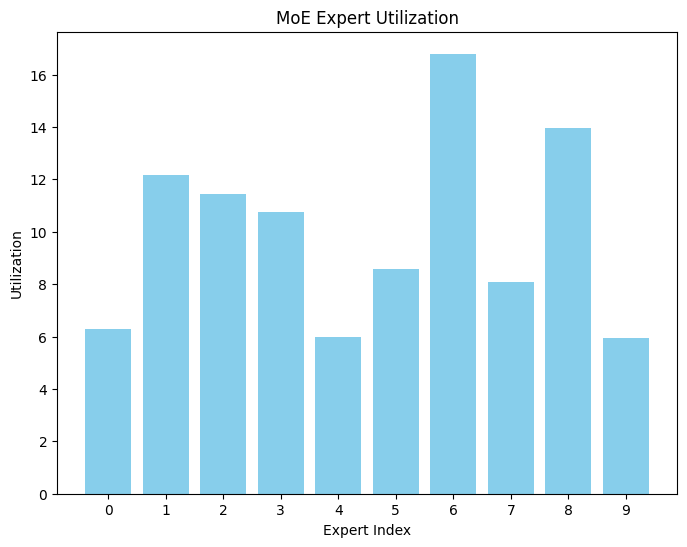

	Epoch 10 Validation: Loss = 0.3167, Accuracy = 0.8670, Recall = 0.6548


Epoch 11/30: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s, accuracy=0.89, loss=0.279] 

	Epoch 11 Training: Loss = 0.2789, Accuracy = 0.8901, Recall = 0.8985


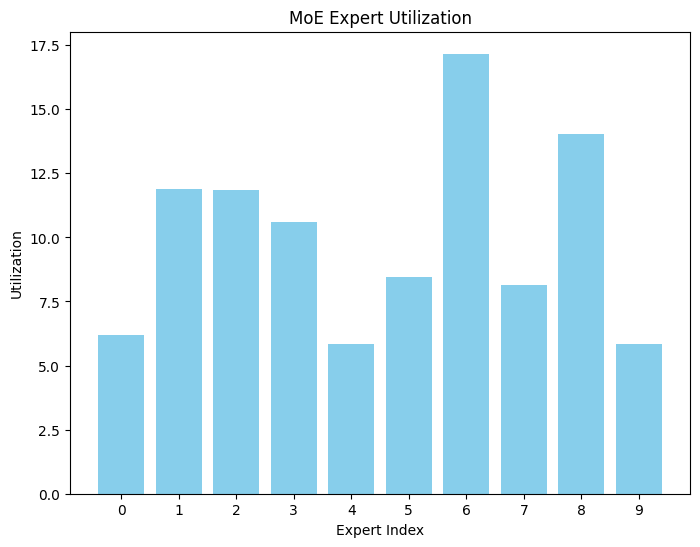

	Epoch 11 Validation: Loss = 0.3719, Accuracy = 0.8486, Recall = 0.7083


Epoch 12/30: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s, accuracy=0.895, loss=0.279]

	Epoch 12 Training: Loss = 0.2791, Accuracy = 0.8952, Recall = 0.9093


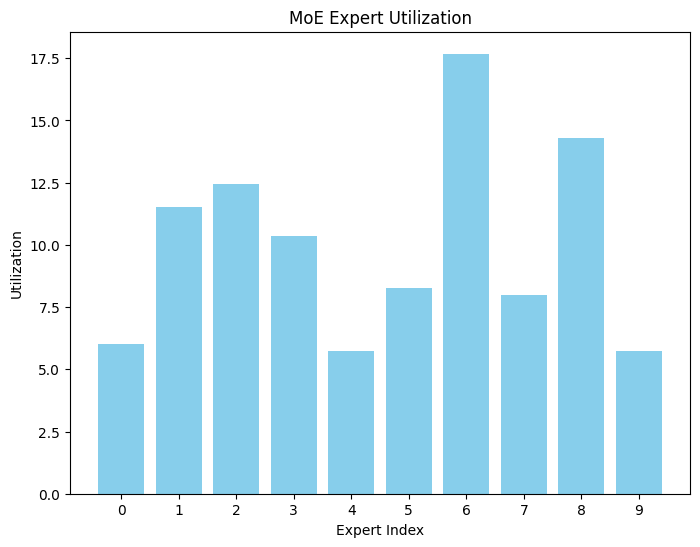

	Epoch 12 Validation: Loss = 0.8650, Accuracy = 0.7752, Recall = 0.2302


Epoch 13/30: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s, accuracy=0.907, loss=0.241]

	Epoch 13 Training: Loss = 0.2410, Accuracy = 0.9071, Recall = 0.9078


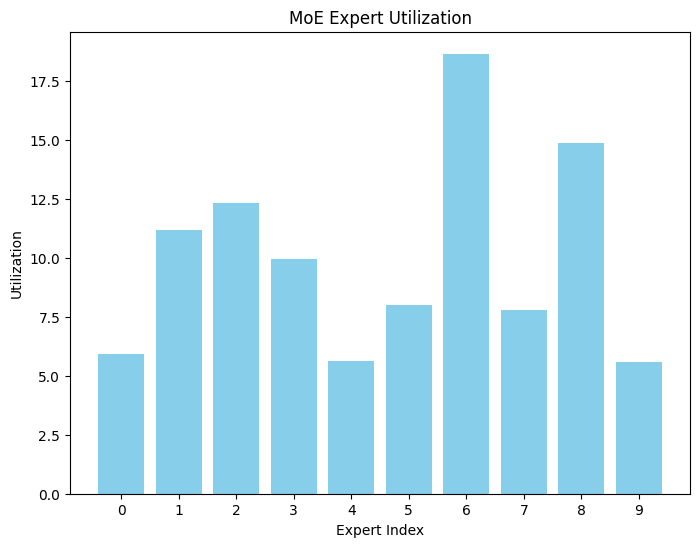

	Epoch 13 Validation: Loss = 0.5033, Accuracy = 0.7798, Recall = 0.9484


Epoch 14/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.894, loss=0.256]

	Epoch 14 Training: Loss = 0.2563, Accuracy = 0.8938, Recall = 0.9144


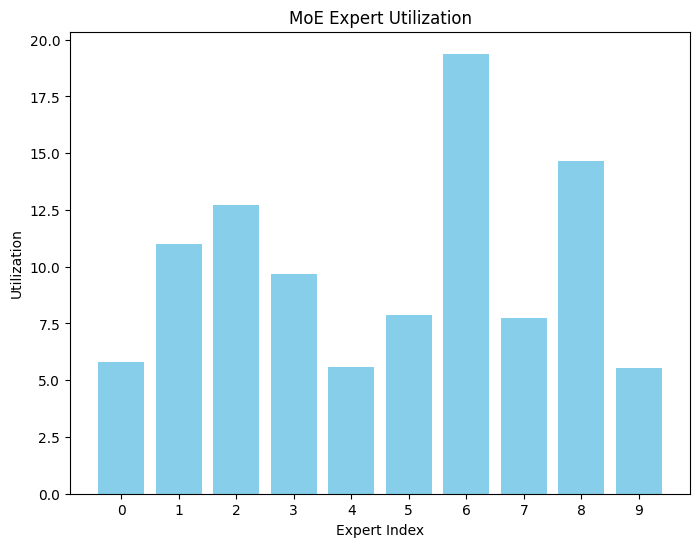

	Epoch 14 Validation: Loss = 0.3500, Accuracy = 0.8303, Recall = 0.9167


Epoch 15/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.907, loss=0.245]


	Epoch 15 Training: Loss = 0.2453, Accuracy = 0.9071, Recall = 0.9254


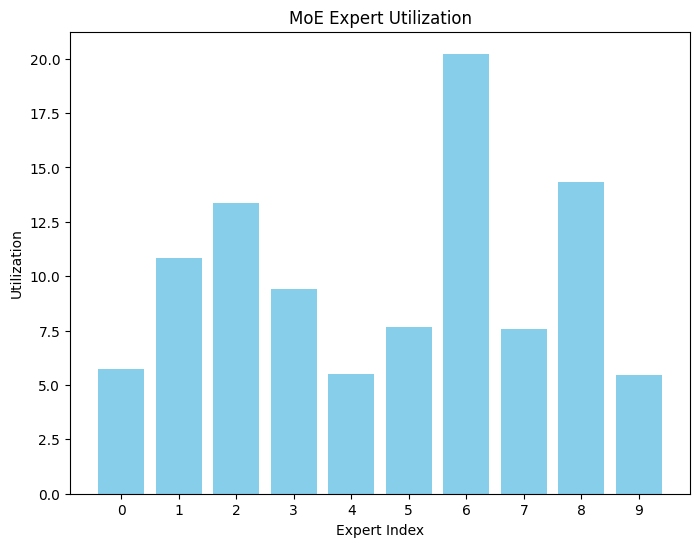

	Epoch 15 Validation: Loss = 0.2844, Accuracy = 0.8624, Recall = 0.9167


Epoch 16/30: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s, accuracy=0.911, loss=0.219]

	Epoch 16 Training: Loss = 0.2190, Accuracy = 0.9108, Recall = 0.9211


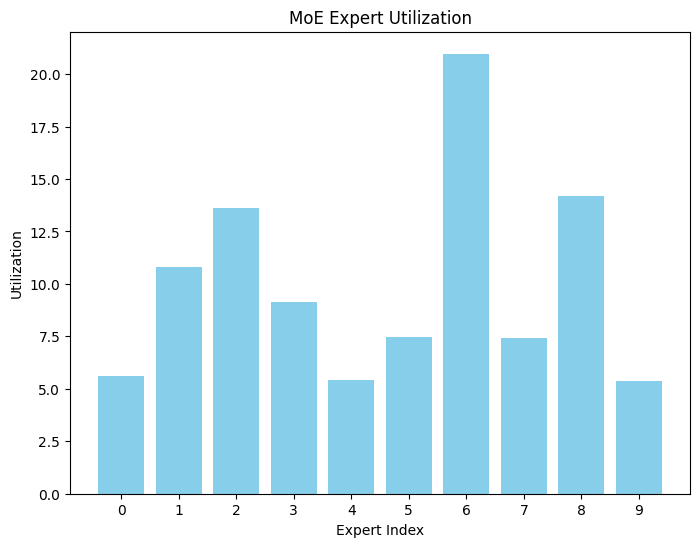

	Epoch 16 Validation: Loss = 0.3524, Accuracy = 0.8394, Recall = 0.9028


Epoch 17/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.919, loss=0.225]

	Epoch 17 Training: Loss = 0.2251, Accuracy = 0.9191, Recall = 0.9344


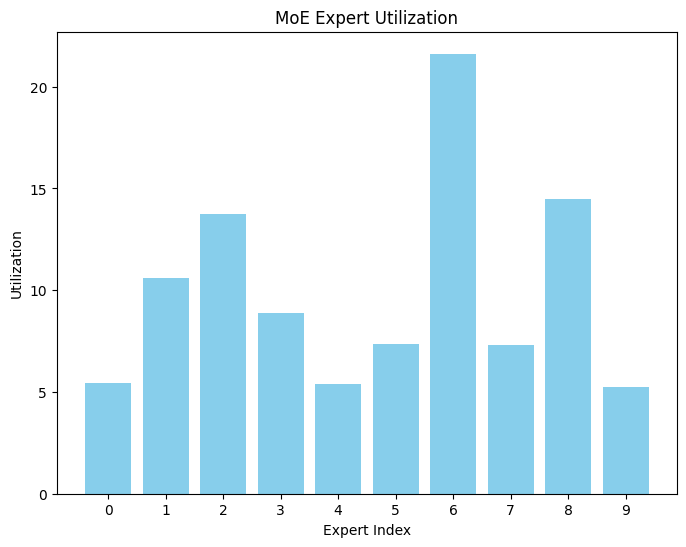

	Epoch 17 Validation: Loss = 0.3511, Accuracy = 0.8532, Recall = 0.9504


Epoch 18/30: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s, accuracy=0.921, loss=0.225]

	Epoch 18 Training: Loss = 0.2252, Accuracy = 0.9209, Recall = 0.9381


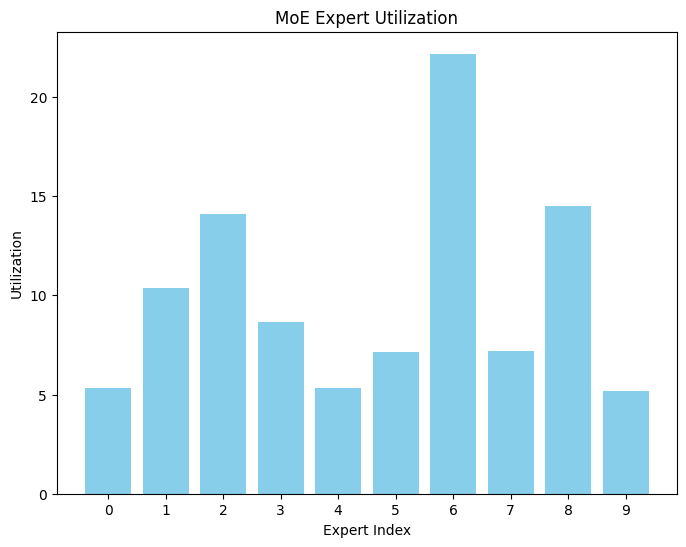

	Epoch 18 Validation: Loss = 0.3243, Accuracy = 0.8670, Recall = 0.6071


Epoch 19/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.918, loss=0.214]

	Epoch 19 Training: Loss = 0.2140, Accuracy = 0.9182, Recall = 0.9321


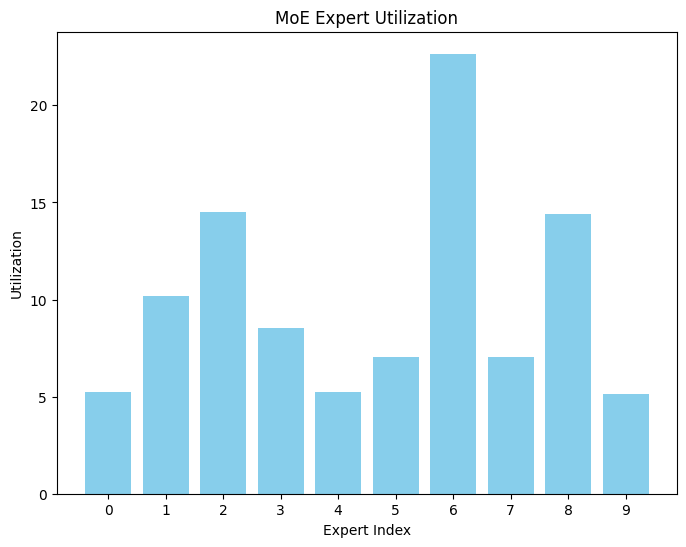

	Epoch 19 Validation: Loss = 0.2842, Accuracy = 0.8532, Recall = 0.9048


Epoch 20/30: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s, accuracy=0.92, loss=0.216] 

	Epoch 20 Training: Loss = 0.2164, Accuracy = 0.9195, Recall = 0.9394


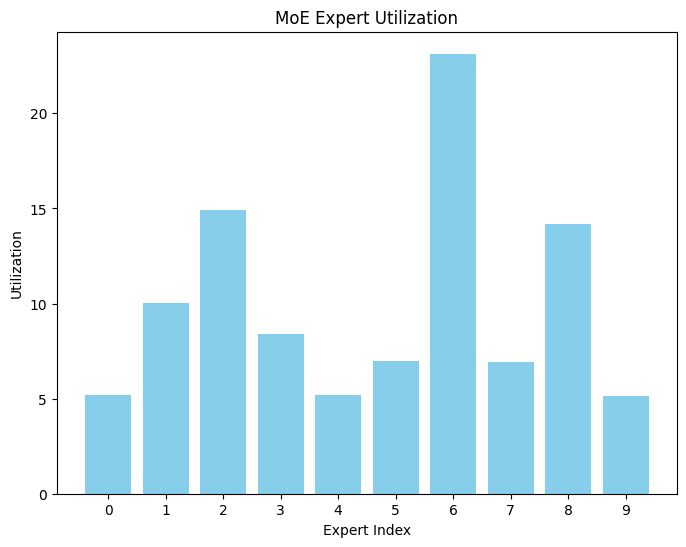

	Epoch 20 Validation: Loss = 0.3002, Accuracy = 0.8532, Recall = 0.8175


Epoch 21/30: 100%|██████████| 68/68 [00:55<00:00,  1.21it/s, accuracy=0.917, loss=0.199]

	Epoch 21 Training: Loss = 0.1986, Accuracy = 0.9172, Recall = 0.9295


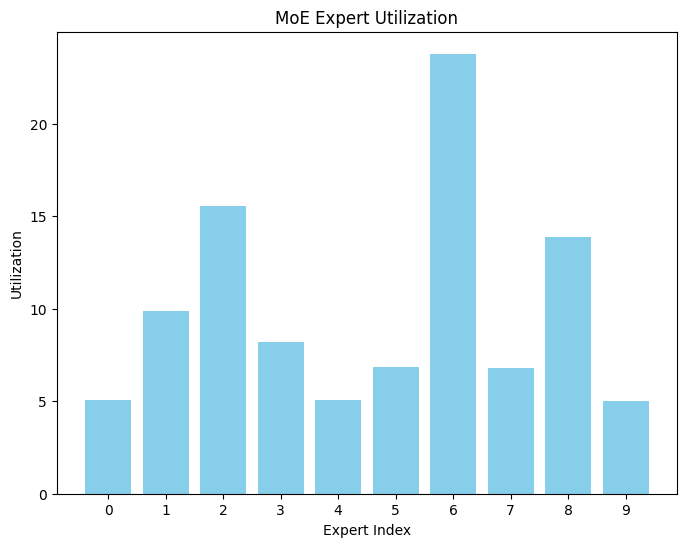

	Epoch 21 Validation: Loss = 0.2977, Accuracy = 0.8761, Recall = 0.8829


Epoch 22/30: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s, accuracy=0.921, loss=0.205]

	Epoch 22 Training: Loss = 0.2050, Accuracy = 0.9209, Recall = 0.9343


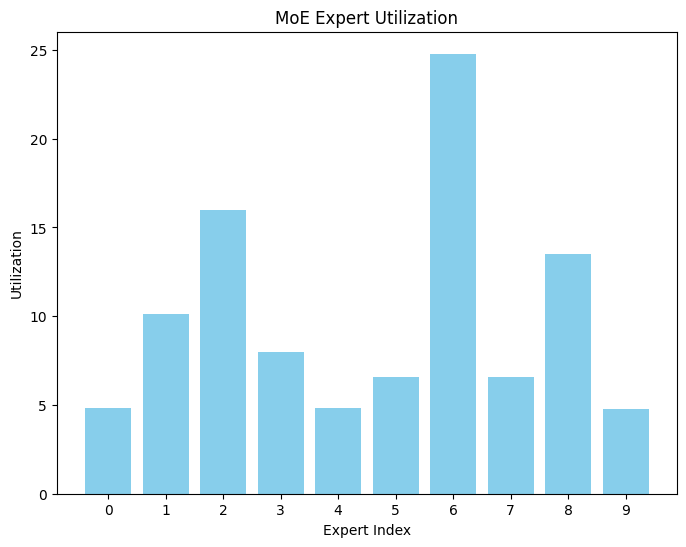

	Epoch 22 Validation: Loss = 0.3690, Accuracy = 0.8532, Recall = 0.8948


Epoch 23/30: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s, accuracy=0.926, loss=0.196]

	Epoch 23 Training: Loss = 0.1958, Accuracy = 0.9264, Recall = 0.9365


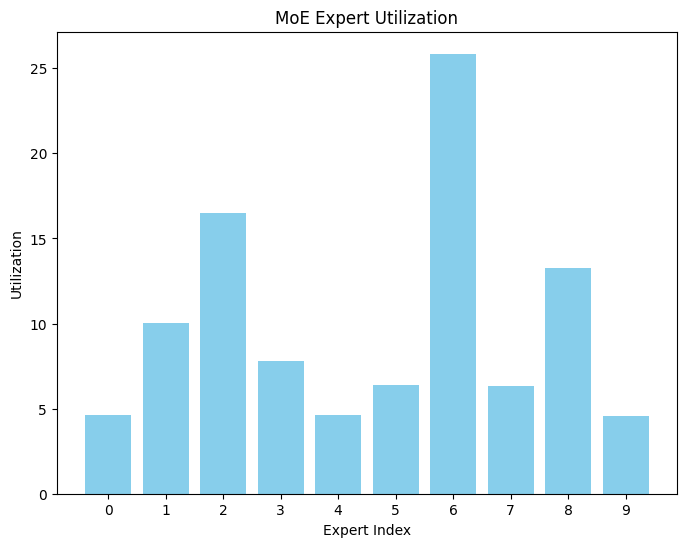

	Epoch 23 Validation: Loss = 0.3160, Accuracy = 0.8716, Recall = 0.8353


Epoch 24/30: 100%|██████████| 68/68 [00:55<00:00,  1.23it/s, accuracy=0.917, loss=0.192]

	Epoch 24 Training: Loss = 0.1916, Accuracy = 0.9172, Recall = 0.9371


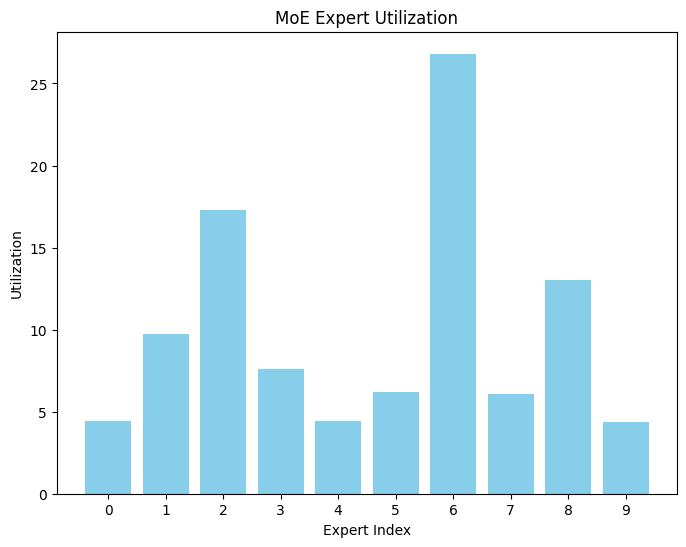

	Epoch 24 Validation: Loss = 0.3042, Accuracy = 0.8761, Recall = 0.7163


Epoch 25/30: 100%|██████████| 68/68 [00:53<00:00,  1.28it/s, accuracy=0.937, loss=0.176]

	Epoch 25 Training: Loss = 0.1763, Accuracy = 0.9375, Recall = 0.9403


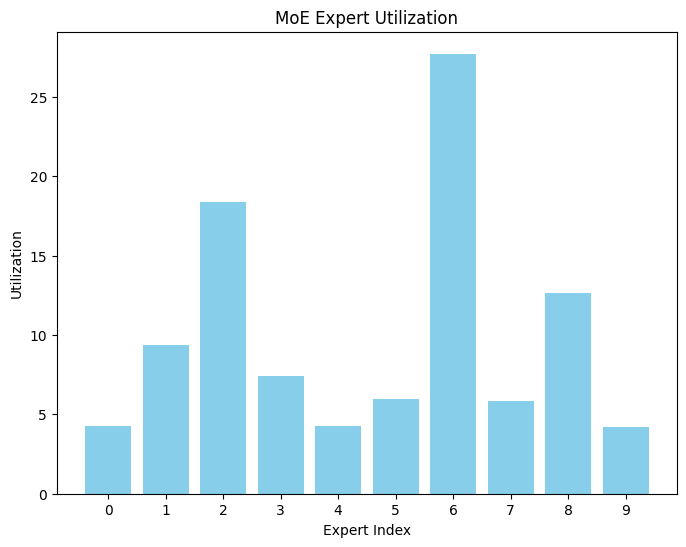

	Epoch 25 Validation: Loss = 0.3092, Accuracy = 0.8853, Recall = 0.8194


Epoch 26/30: 100%|██████████| 68/68 [00:52<00:00,  1.29it/s, accuracy=0.938, loss=0.167]

	Epoch 26 Training: Loss = 0.1670, Accuracy = 0.9384, Recall = 0.9458


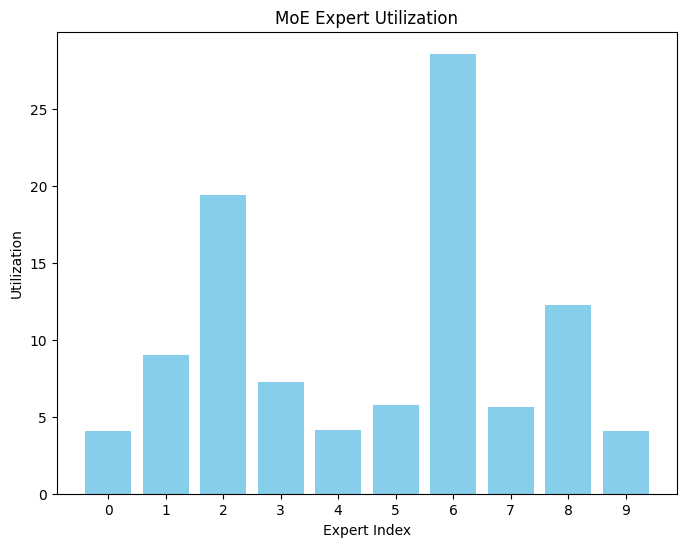

	Epoch 26 Validation: Loss = 0.4271, Accuracy = 0.8716, Recall = 0.5893


Epoch 27/30: 100%|██████████| 68/68 [00:53<00:00,  1.27it/s, accuracy=0.945, loss=0.167] 

	Epoch 27 Training: Loss = 0.1667, Accuracy = 0.9448, Recall = 0.9426


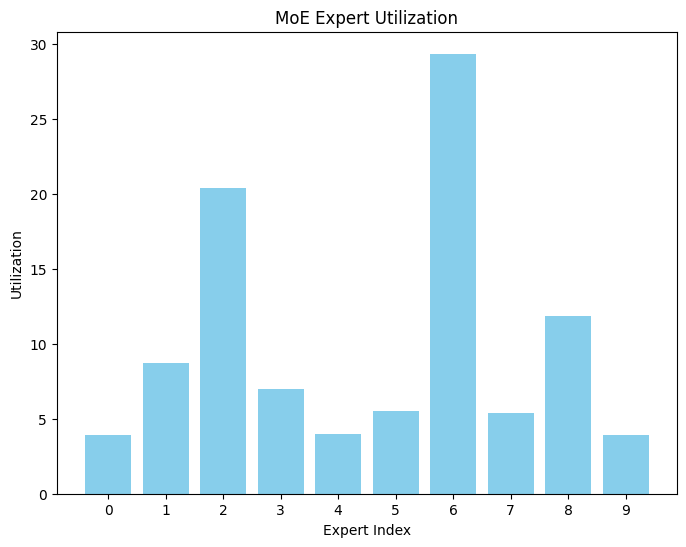

	Epoch 27 Validation: Loss = 0.2924, Accuracy = 0.8761, Recall = 0.7877


Epoch 28/30: 100%|██████████| 68/68 [01:01<00:00,  1.11it/s, accuracy=0.941, loss=0.152]

	Epoch 28 Training: Loss = 0.1518, Accuracy = 0.9407, Recall = 0.9542


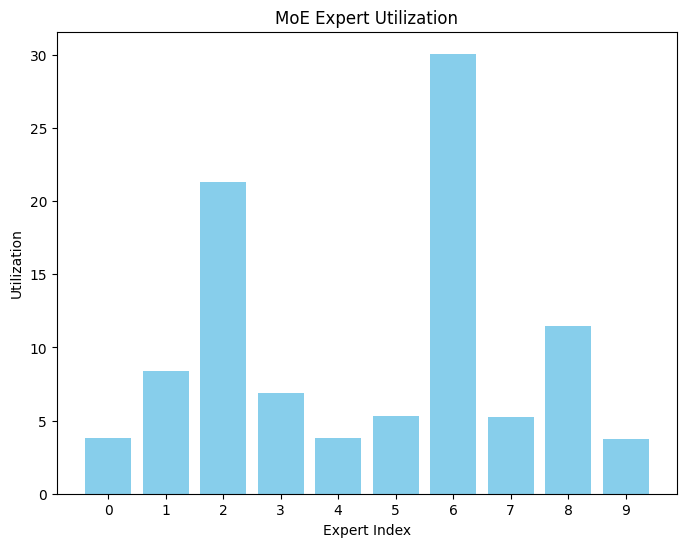

	Epoch 28 Validation: Loss = 0.2540, Accuracy = 0.8899, Recall = 0.8393


Epoch 29/30: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s, accuracy=0.948, loss=0.149]

	Epoch 29 Training: Loss = 0.1492, Accuracy = 0.9476, Recall = 0.9492


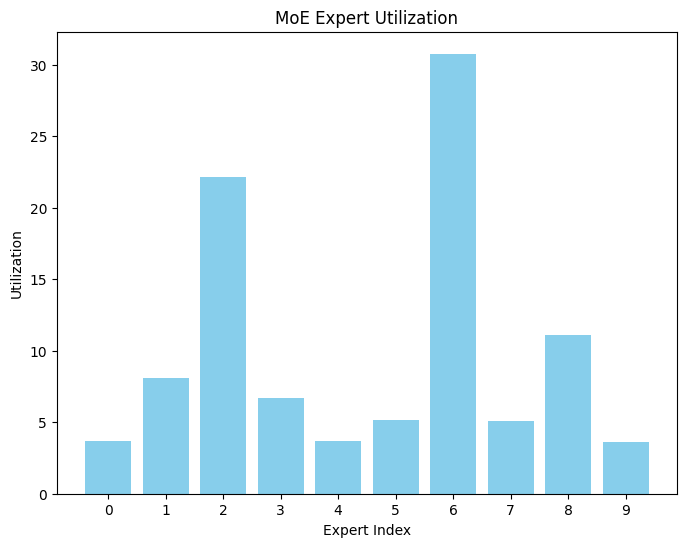

	Epoch 29 Validation: Loss = 0.2904, Accuracy = 0.8440, Recall = 0.7877


Epoch 30/30: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, accuracy=0.942, loss=0.142]

	Epoch 30 Training: Loss = 0.1421, Accuracy = 0.9416, Recall = 0.9518


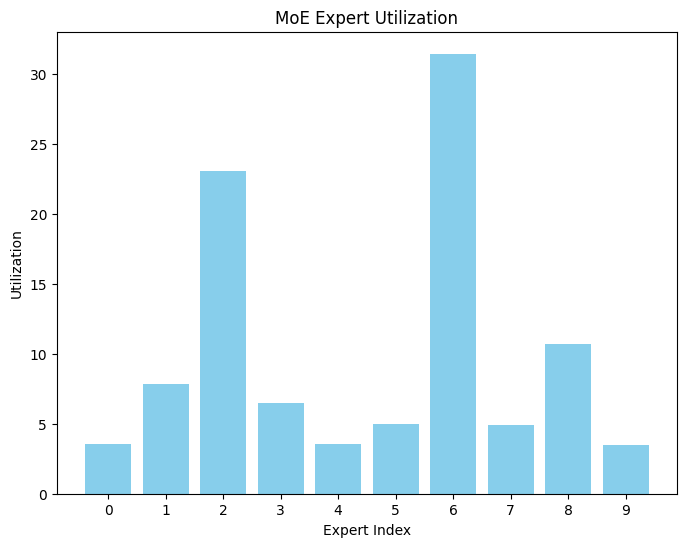

	Epoch 30 Validation: Loss = 0.3217, Accuracy = 0.8807, Recall = 0.7659
Training Complete!


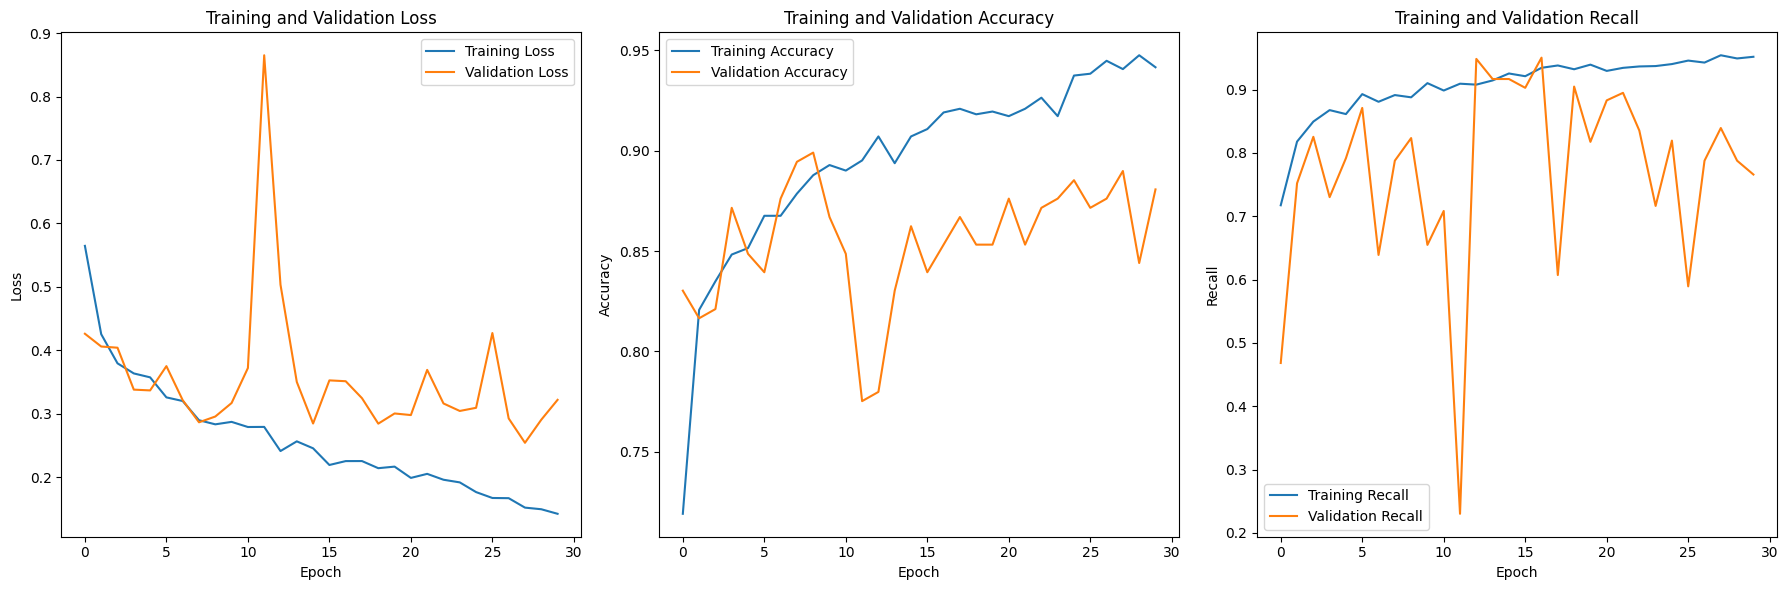

In [65]:
class_hidden_dims = None
num_classes = 2
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)

enhancement_params={'num_experts': 10, 'output_dim': 64, 'top_k': 2, 'temperature':2, 'reduction':8}
model_moe_nostain = FeatureExtractorClassifier(
    backbone_encoder=backbone,
    num_classes=num_classes,
    enhancement_type='moe',
    enhancement_params=enhancement_params,
    class_hidden_dims=class_hidden_dims
)


print(count_parameters(model_moe_nostain))

# model.classifier.initialize_bias(1/class_weights_tensor)
# criterion = FocalLoss()
criterion =  nn.CrossEntropyLoss()

model_moe_nostain.enhancement_block._initialize_parameters()
train(
    model=model_moe_nostain, 
    train_loader=train_loader_nostain, 
    val_loader=val_loader_nostain, 
    criterion=criterion, 
    epochs=30, 
    batch_size=batch_size, 
    base_lr=1e-4, 
    weight_decay=1e-4, 
    max_grad_norm=1.0, 
    save_path=None,
    use_scheduler=False,
    val_acc_threshold=1,
    val_rec_threshold=1
)

Test Accuracy: 84.75%
Test Recall: 79.72%


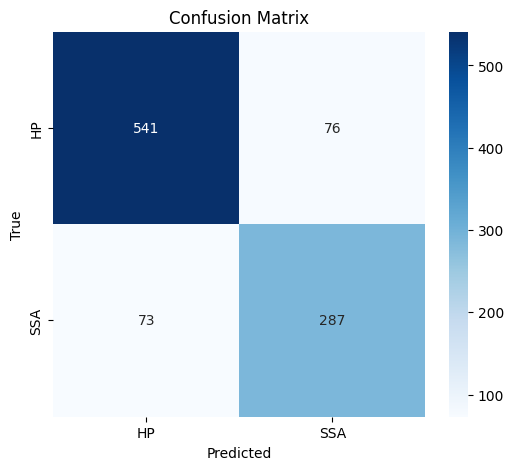

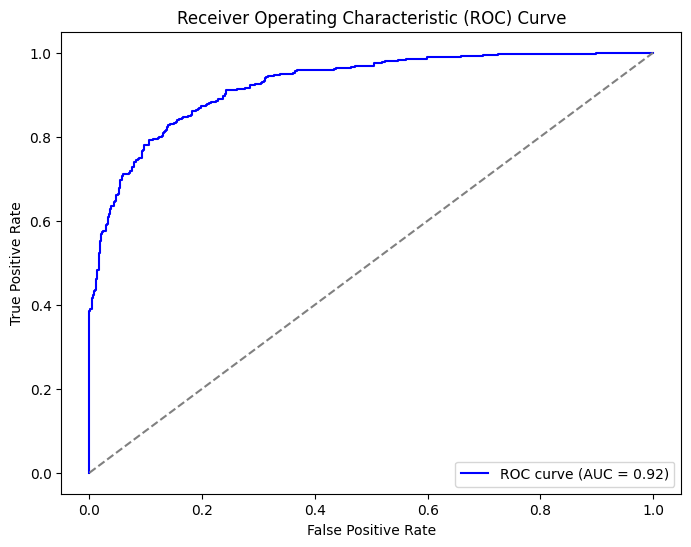

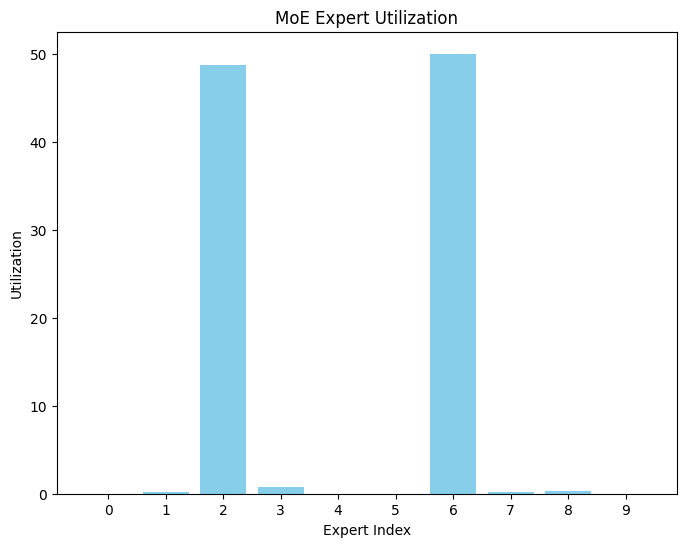

In [66]:
test_roc(model_moe_nostain.to(device),test_loader_nostain,device=device, show_expert_util=True);

Test Accuracy: 70.21%
Test Recall: 23.61%


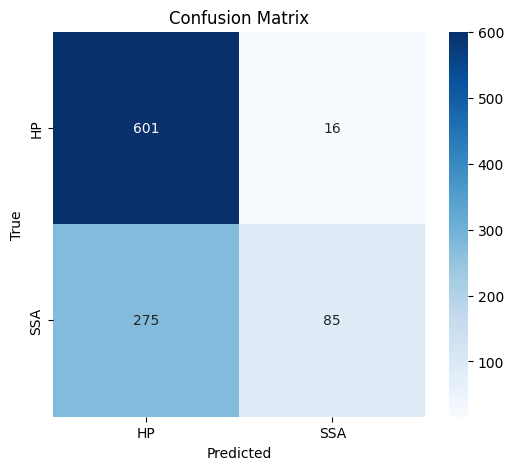

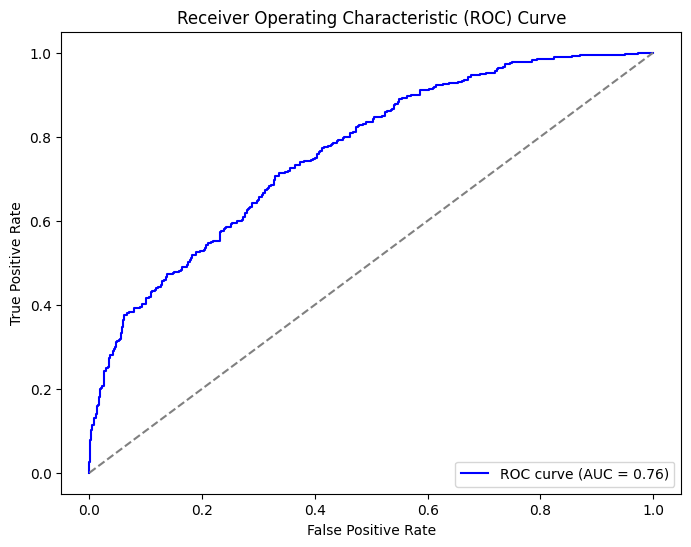

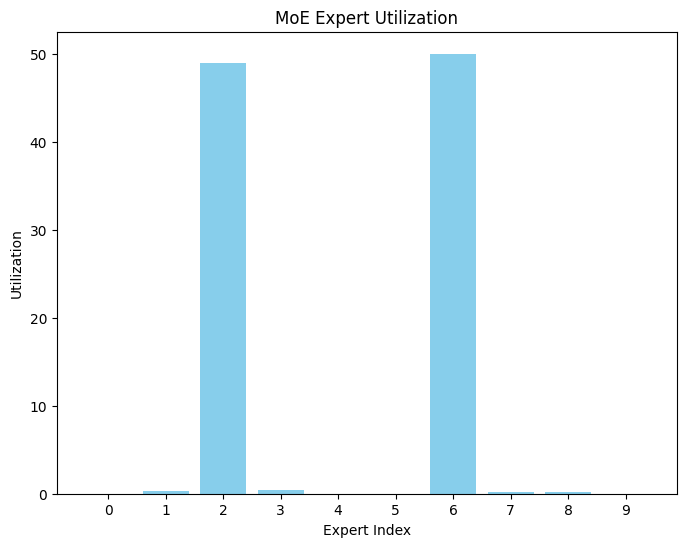

In [67]:
test_roc(model_moe_nostain.to(device),test_loader_stain,device=device, show_expert_util=True);

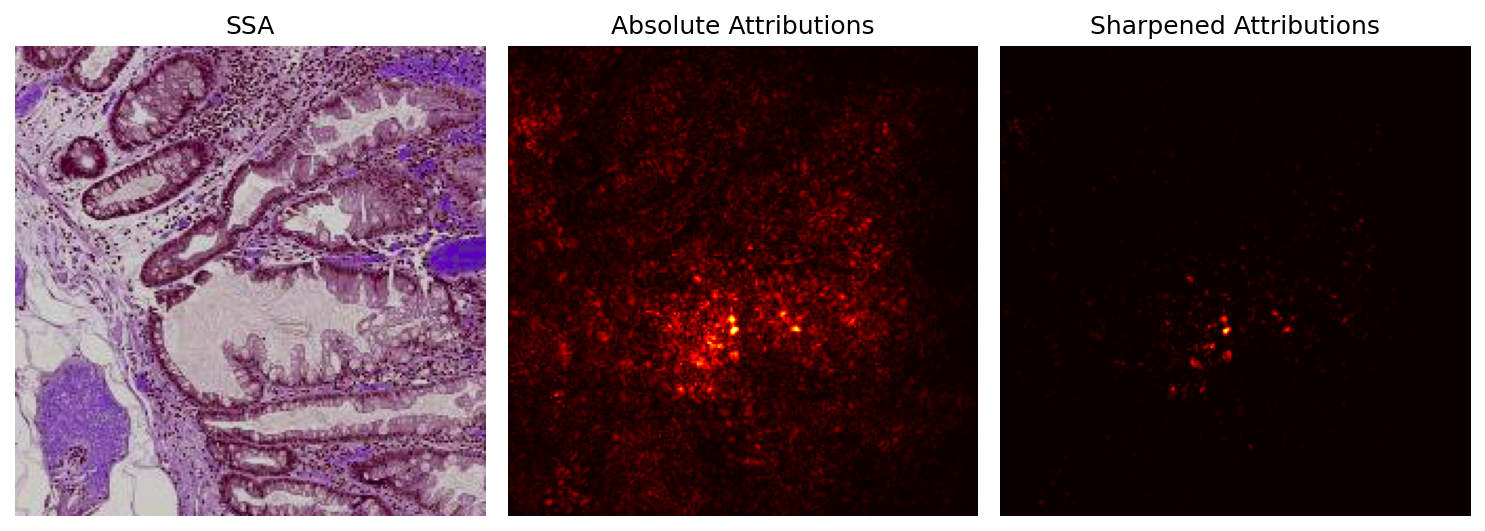

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import random

# Ensure the model is on the correct device (MPS) and in float32
model_moe_nostain.eval().to(torch.float32).cpu()

random_idx = random.randint(0, len(test_dataset_stain) - 1)
random_idx = 865
# Get the image and label corresponding to the random index
image_to_explore, label_to_explore = test_dataset_stain[random_idx]  # Sample random image and label
image_to_explore = image_to_explore.unsqueeze(0).to(torch.float32)  # Add batch dimension (1, C, H, W) if needed
image_np = image_to_explore.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

# Initialize Integrated Gradients
ig = IntegratedGradients(model_moe_nostain)

# Compute the attributions
attributions, delta = ig.attribute(image_to_explore, target=label_to_explore, return_convergence_delta=True)

# Convert attributions to NumPy
attributions = attributions.squeeze(0).cpu().detach().numpy()

# Sharpen the attributions by squaring
attributions_sharpened = attributions ** 2  # Element-wise squaring

# Normalize the original image for display
# image_np = image_to_explore.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
# image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Normalize the sharpened attributions for display
attributions_sharpened_norm = (attributions_sharpened[0] - attributions_sharpened[0].min()) / \
                              (attributions_sharpened[0].max() - attributions_sharpened[0].min())

attributions_sum = np.sum(np.abs(attributions), axis=0)


# Plot the original image and sharpened attributions side by side
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=150)  # Increase dpi to improve resolution

label_map = {1: 'SSA', 0: 'HP'}

# Original image
axes[0].imshow(image_np)
axes[0].set_title(f"{label_map[label_to_explore]}")
axes[0].axis("off")

# Sharpened attribution map
axes[1].imshow(attributions_sum, cmap='hot')  # Normalized sharpened attribution map
axes[1].set_title(f"Absolute Attributions")
axes[1].axis("off")

# Absolute attribution map
axes[2].imshow(attributions_sharpened_norm, cmap='hot')  # Normalized sharpened attribution map
axes[2].set_title(f"Sharpened Attributions")
axes[2].axis("off")

plt.tight_layout()
plt.show()

(977, 3136)


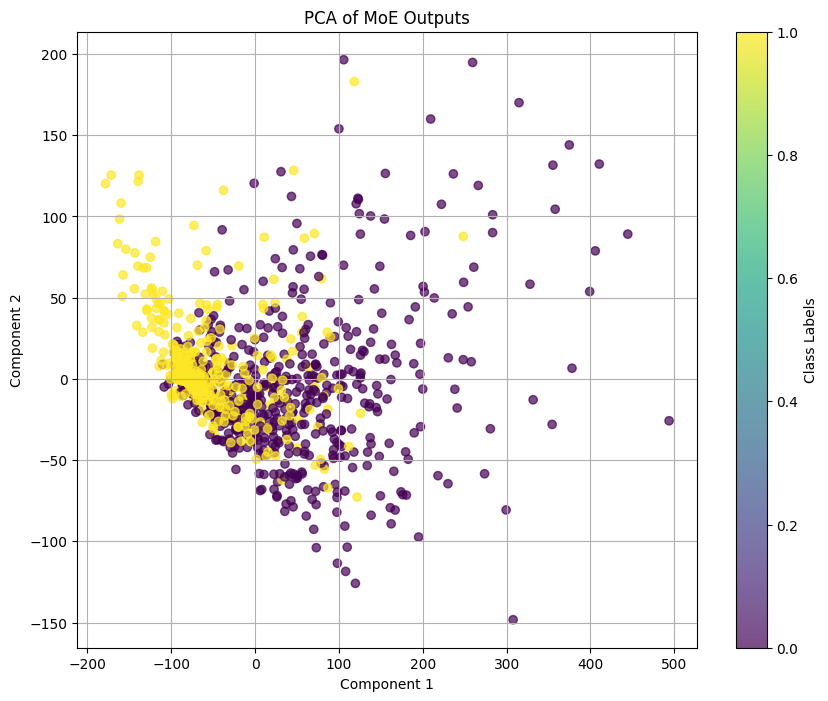

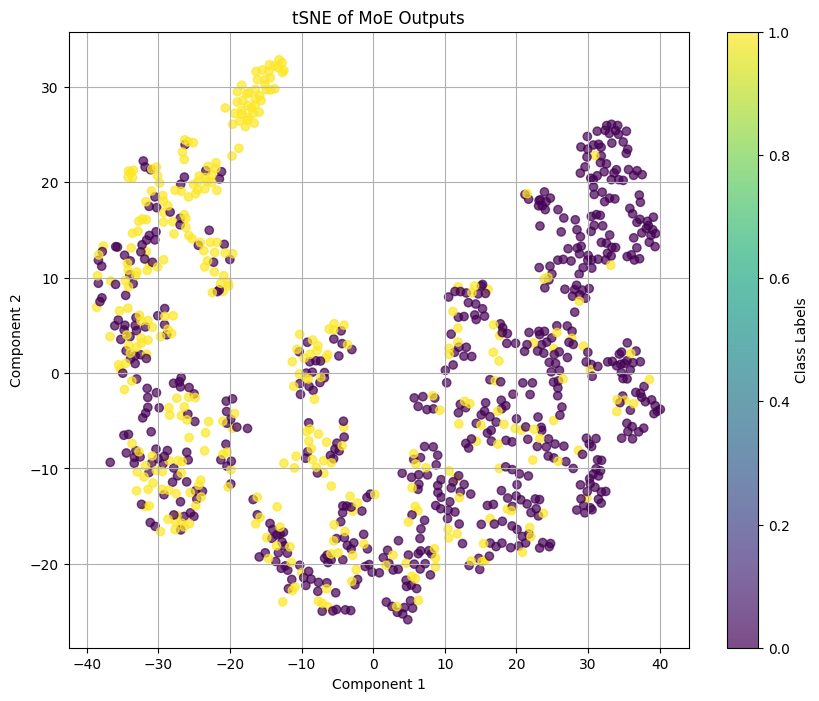

In [72]:
analyze_moe_outputs_with_pca(model_moe_nostain,test_loader_stain);

/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:35:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454143039/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with 200 PCA components: 66.53%


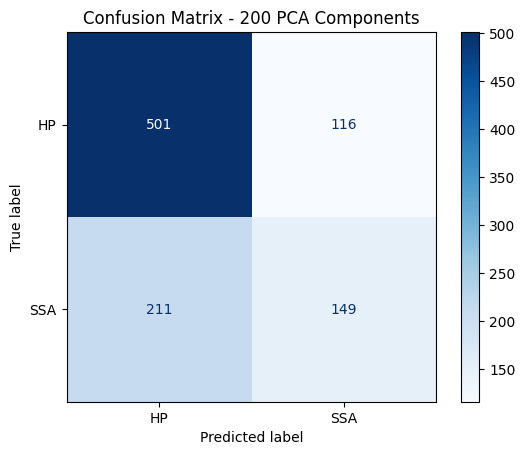

/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454143039/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with 100 PCA components: 68.07%


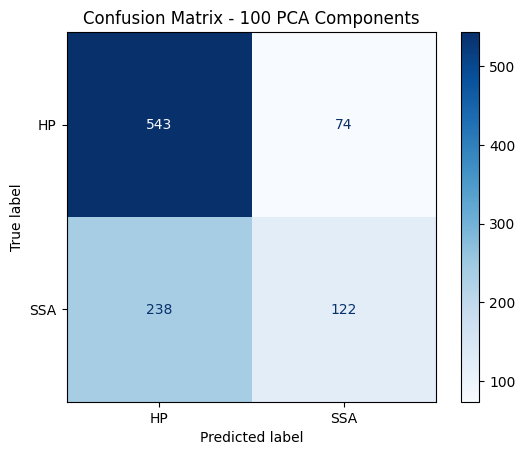

/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [12:35:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454143039/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with 50 PCA components: 68.47%


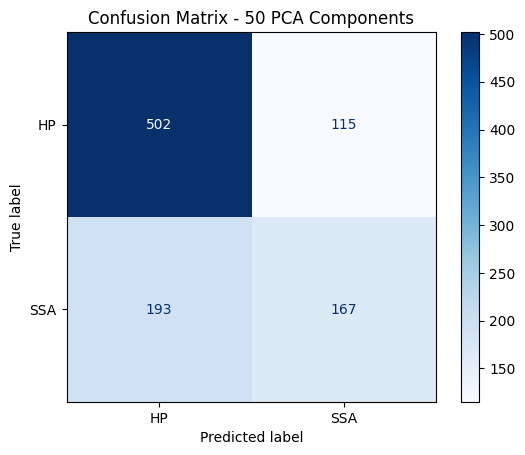

In [30]:
import torch
import xgboost as xgb
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten the images and convert them to numpy arrays
def flatten_dataset(dataset):
    flattened_images = []
    labels = []
    for img, label in dataset:
        flattened_images.append(img.view(-1).numpy())  # Flatten the image
        labels.append(label)
    return np.array(flattened_images), np.array(labels)

# Flatten train and test datasets
X_train, y_train = flatten_dataset(train_dataset)
X_test, y_test = flatten_dataset(test_dataset)

# Apply PCA for dimensionality reduction
pca_200 = PCA(n_components=200)  # Reduce to 200 components
X_train_pca_200 = pca_200.fit_transform(X_train)
X_test_pca_200 = pca_200.transform(X_test)

# Apply PCA for dimensionality reduction
pca_100 = PCA(n_components=100)  # Reduce to 100 components
X_train_pca_100 = pca_100.fit_transform(X_train)
X_test_pca_100 = pca_100.transform(X_test)

pca_50 = PCA(n_components=50)  # Reduce to 50 components
X_train_pca_50 = pca_50.fit_transform(X_train)
X_test_pca_50 = pca_50.transform(X_test)

# Calculate class weights (if classes are imbalanced)
class_counts = np.bincount(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]  # Assuming 0 = HP and 1 = SSA

# Create and train the XGBoost model (using PCA with 200 components) with class weight
model_200 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=scale_pos_weight)
model_200.fit(X_train_pca_200, y_train)

# Evaluate the model on the test set (using PCA with 200 components)
accuracy_200 = model_200.score(X_test_pca_200, y_test)
print(f"Accuracy with 200 PCA components: {accuracy_200 * 100:.2f}%")

# Confusion Matrix for model 200
y_pred_200 = model_200.predict(X_test_pca_200)
cm_200 = confusion_matrix(y_test, y_pred_200, labels=[0, 1])  # Assuming 0 = HP, 1 = SSA
disp_200 = ConfusionMatrixDisplay(confusion_matrix=cm_200, display_labels=["HP", "SSA"])
disp_200.plot(cmap='Blues')
plt.title("Confusion Matrix - 200 PCA Components")
plt.show()

# Create and train the XGBoost model (using PCA with 100 components) with class weight
model_100 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=scale_pos_weight)
model_100.fit(X_train_pca_100, y_train)

# Evaluate the model on the test set (using PCA with 100 components)
accuracy_100 = model_100.score(X_test_pca_100, y_test)
print(f"Accuracy with 100 PCA components: {accuracy_100 * 100:.2f}%")

# Confusion Matrix for model 100
y_pred_100 = model_100.predict(X_test_pca_100)
cm_100 = confusion_matrix(y_test, y_pred_100, labels=[0, 1])
disp_100 = ConfusionMatrixDisplay(confusion_matrix=cm_100, display_labels=["HP", "SSA"])
disp_100.plot(cmap='Blues')
plt.title("Confusion Matrix - 100 PCA Components")
plt.show()

# Create and train the XGBoost model (using PCA with 50 components) with class weight
model_50 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=scale_pos_weight)
model_50.fit(X_train_pca_50, y_train)

# Evaluate the model on the test set (using PCA with 50 components)
accuracy_50 = model_50.score(X_test_pca_50, y_test)
print(f"Accuracy with 50 PCA components: {accuracy_50 * 100:.2f}%")

# Confusion Matrix for model 50
y_pred_50 = model_50.predict(X_test_pca_50)
cm_50 = confusion_matrix(y_test, y_pred_50, labels=[0, 1])
disp_50 = ConfusionMatrixDisplay(confusion_matrix=cm_50, display_labels=["HP", "SSA"])
disp_50.plot(cmap='Blues')
plt.title("Confusion Matrix - 50 PCA Components")
plt.show()

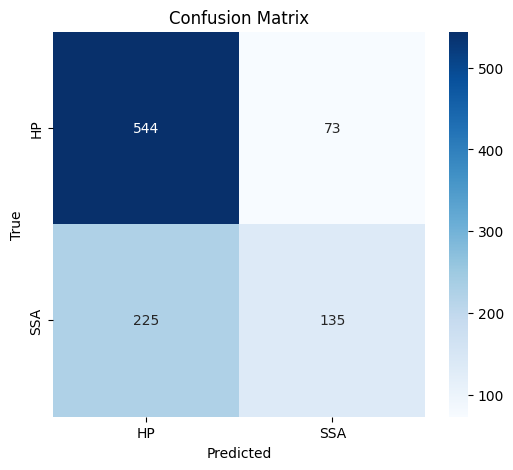

Accuracy: 69.50%


In [66]:
# Make predictions
y_pred = model_200.predict(X_test_pca_200)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['HP', 'SSA'], yticklabels=['HP', 'SSA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
from skimage.feature import local_binary_pattern

# Extract LBP features from each image
def extract_lbp_features(dataset):
    lbp_features = []
    labels = []
    for img, label in dataset:
        img = img.numpy().transpose(1, 2, 0)
        # Convert the image to grayscale
        img_gray = np.mean(img, axis=-1)
        
        # Compute LBP features
        lbp = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
        # Compute a histogram of the LBP image
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize the histogram
        lbp_features.append(lbp_hist)
        labels.append(label)
    
    return np.array(lbp_features), np.array(labels)

# Extract features for train and test datasets
X_train_lbp, y_train_lbp = extract_lbp_features(train_dataset)
X_test_lbp, y_test_lbp = extract_lbp_features(test_dataset)



/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Accuracy with LBP features: 62.44%


/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:40:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454143039/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [63]:
# Create and train the XGBoost model (using LBP features)
model_lbp = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',scale_pos_weight=class_weights[1],max_depth=6,learning_rate=0.01, num_estimators = 1000)
model_lbp.fit(X_train_lbp, y_train_lbp)

# Evaluate the model on the test set
accuracy_lbp = model_lbp.score(X_test_lbp, y_test_lbp)
print(f"Accuracy with LBP features: {accuracy_lbp * 100:.2f}%")

Accuracy with LBP features: 55.07%


/Users/panos/opt/anaconda3/envs/pytorch_tut/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:45:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1722454143039/work/src/learner.cc:740: 
Parameters: { "num_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


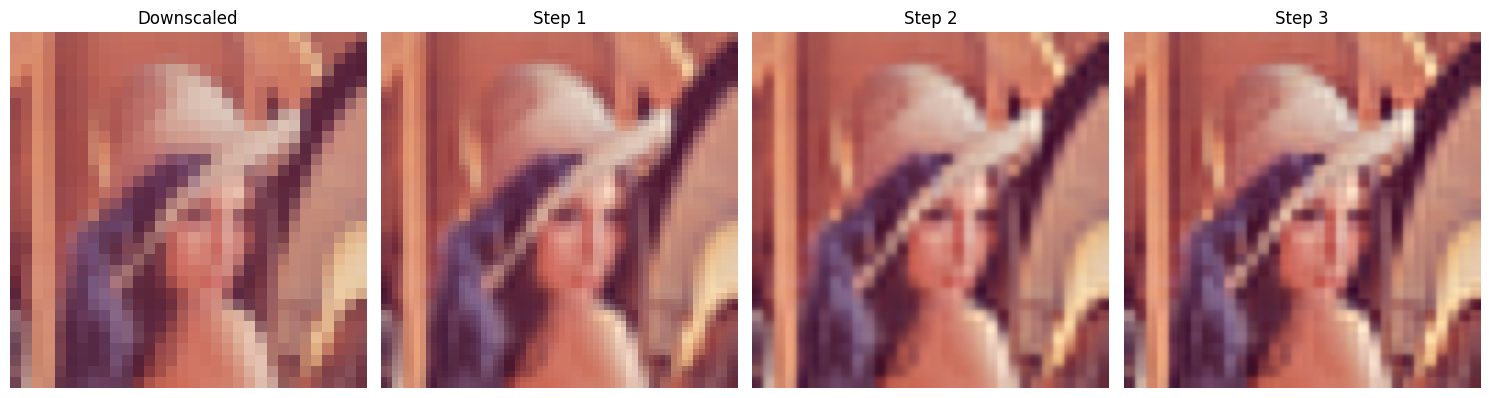

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from scipy.ndimage import gaussian_filter

def load_lena_image():
    """
    Load a standard test image (Lena).
    Note: Since we can't actually load the image here, 
    you'll need to replace this with a path to an actual image.
    """
    # Placeholder - replace with an actual image path
    try:
        # Example usage
        lena_path = '/Users/panos/Downloads/Lenna_(test_image).png'
        image = io.imread(lena_path)
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        # Create a synthetic image if loading fails
        return np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)

def downsample_image(image, factor=16):
    """
    Downsample the image using Gaussian filtering and rescaling
    
    Args:
    - image (numpy.ndarray): Input image
    - factor (int): Downscaling factor
    
    Returns:
    - Downscaled image
    """
    # Apply Gaussian blur to reduce aliasing
    blurred = gaussian_filter(image, sigma=0.5)
    
    # Resize using skimage
    downscaled = transform.resize(
        blurred, 
        (image.shape[0] // factor, image.shape[1] // factor),
        anti_aliasing=True,
        preserve_range=True
    ).astype(np.uint8)
    
    return downscaled

def bilinear_upscale(image, scale_factor=2):
    """
    Upscale image using bilinear interpolation
    
    Args:
    - image (numpy.ndarray): Input image
    - scale_factor (int): Upscaling factor
    
    Returns:
    - Upscaled image
    """
    # Convert to torch tensor
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)
    
    # Bilinear upscaling
    upscaled_tensor = F.interpolate(
        image_tensor, 
        scale_factor=scale_factor, 
        mode='bilinear', 
        align_corners=False
    )
    
    return upscaled_tensor

def apply_sharpening(image_tensor):
    """
    Apply custom sharpening kernel
    
    Args:
    - image_tensor (torch.Tensor): Input image tensor
    
    Returns:
    - Sharpened image tensor
    """
    # Define sharpening kernel
    sharpening_kernel = torch.tensor([[0, -1, 0], 
                                      [-1, 5, -1], 
                                      [0, -1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Prepare kernel for each channel
    sharpening_kernel = sharpening_kernel.repeat(image_tensor.shape[1], 1, 1, 1)
    
    # Apply convolution for each channel
    padded = F.pad(image_tensor, (1, 1, 1, 1), mode='replicate')
    sharpened = F.conv2d(padded, sharpening_kernel, groups=image_tensor.shape[1])
    
    return sharpened

def progressive_upscale(image, initial_downscale_factor=16, steps=3):
    """
    Progressively upscale the image after initial downscaling
    
    Args:
    - image (numpy.ndarray): Input image
    - initial_downscale_factor (int): Factor to initially downscale the image
    - steps (int): Number of upscaling steps
    
    Returns:
    - List of upscaled images
    """
    # Downscale the original image first
    downscaled_image = downsample_image(image, factor=initial_downscale_factor)
    
    # List to store upscaled images
    upscaled_images = [downscaled_image]
    
    # Current image tensor for iteration
    current_image_tensor = torch.from_numpy(downscaled_image).permute(2, 0, 1).float().unsqueeze(0)
    
    # Progressive upscaling
    for step in range(steps):
        # Upscale the image
        upscaled_tensor = bilinear_upscale(current_image_tensor.squeeze().permute(1, 2, 0).numpy(), scale_factor=2)
        
        # Apply sharpening
        sharpened_tensor = apply_sharpening(upscaled_tensor)
        
        # Convert back to numpy
        sharpened_image = sharpened_tensor.squeeze().permute(1, 2, 0).detach().numpy()
        sharpened_image = np.clip(sharpened_image, 0, 255).astype(np.uint8)
        
        upscaled_images.append(sharpened_image)
        current_image_tensor = torch.from_numpy(sharpened_image).permute(2, 0, 1).float().unsqueeze(0)
    
    return upscaled_images

def plot_upscaled_images(images):
    """
    Plot the original and upscaled images
    
    Args:
    - images (list): List of images to plot
    """
    plt.figure(figsize=(15, 5))
    
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.title(f'Step {i}' if i > 0 else 'Downscaled')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    # Load the image
    original_image = load_lena_image()
    
    # Perform progressive upscaling
    upscaled_images = progressive_upscale(original_image, initial_downscale_factor=16, steps=3)
    
    # Plot the results
    plot_upscaled_images(upscaled_images)

if __name__ == '__main__':
    main()

# Note: This script requires:
# - Replacing load_lena_image() with an actual image path
# - Installing required libraries:
#   pip install torch numpy scikit-image matplotlib scipy

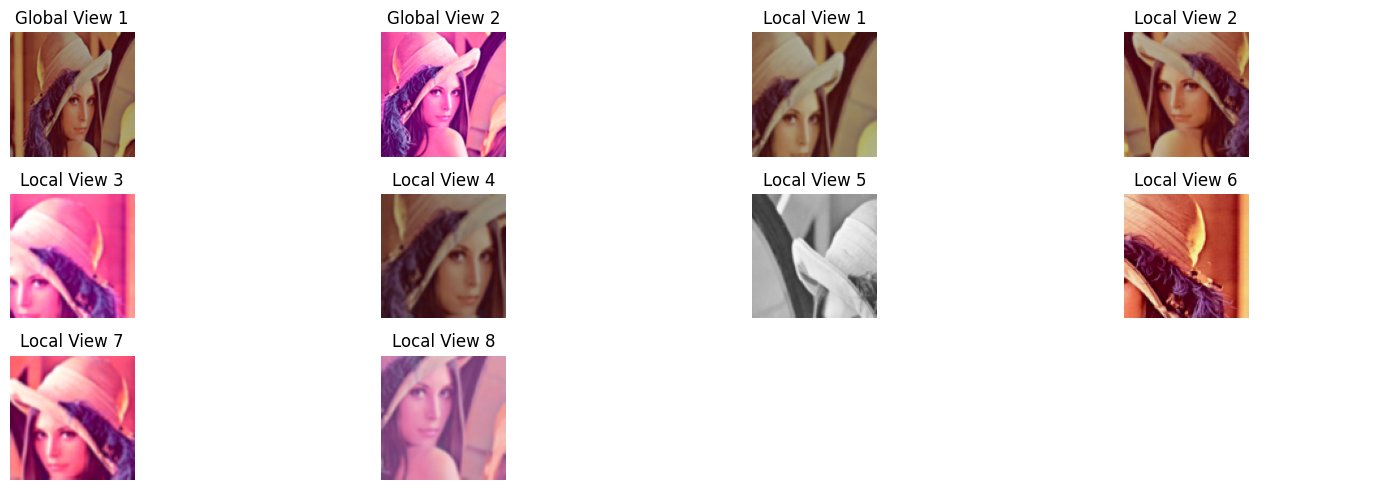

In [8]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# Define transformations for global and local crops
global_transform = T.Compose([
    T.RandomResizedCrop(size=224, scale=(0.5, 1.0), ratio=(0.75, 1.33)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.ToTensor()
])

local_transform = T.Compose([
    T.RandomResizedCrop(size=96, scale=(0.05, 0.5), ratio=(0.75, 1.33)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.ToTensor()
])

# Function to generate views
def generate_views(image, num_global=2, num_local=8):
    global_views = [global_transform(image) for _ in range(num_global)]
    local_views = [local_transform(image) for _ in range(num_local)]
    return global_views, local_views

# Load an image
image_path = '/Users/panos/Downloads/Lenna_(test_image).png'  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Generate views
global_views, local_views = generate_views(image)

# Display the views
def show_images(images, titles, ncols=4):
    n_images = len(images)
    nrows = (n_images // ncols) + (n_images % ncols > 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5))
    axes = axes.flatten()
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axes[i].set_title(title)
        axes[i].axis('off')
    
    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Prepare images and titles for display
global_titles = [f"Global View {i+1}" for i in range(len(global_views))]
local_titles = [f"Local View {i+1}" for i in range(len(local_views))]
all_images = global_views + local_views
all_titles = global_titles + local_titles

# Show the images
show_images(all_images, all_titles)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
from copy import deepcopy

class MultiCropTransform:
    def __init__(self, global_crop_size=32, local_crop_size=24, n_global_views=2, n_local_views=6):
        self.global_crop_transform = transforms.Compose([
            transforms.Resize((global_crop_size, global_crop_size)),
            transforms.RandomResizedCrop(global_crop_size, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
        ])
        self.local_crop_transform = transforms.Compose([
            transforms.Resize((local_crop_size, local_crop_size)),
            transforms.RandomResizedCrop(local_crop_size, scale=(0.2, 0.5)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
        ])
        self.n_global_views = n_global_views
        self.n_local_views = n_local_views

    def __call__(self, img):
        crops = []
        # Create global crops
        for _ in range(self.n_global_views):
            crops.append(self.global_crop_transform(img))
        # Create local crops
        for _ in range(self.n_local_views):
            crops.append(self.local_crop_transform(img))
        return crops  # List of global and local crops
    
class MultiCropDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        # Get the image from the original dataset
        img, _ = self.dataset[idx]
        crops = self.transform(img)  # Apply multi-crop transformations

        return crops  # Return the list of crops (global + local)

    def __len__(self):
        return len(self.dataset)
    
class DINOLoss(nn.Module):
    def __init__(self, out_dim, teacher_temp, student_temp, center_momentum):
        super().__init__()
        self.teacher_temp = teacher_temp
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))

    def forward(self, student_outputs, teacher_outputs):
        """
        Compute the DINO loss across all views.
        """
        loss = 0
        for teacher_output in teacher_outputs:
            teacher_output = teacher_output / self.teacher_temp
            teacher_probs = nn.functional.softmax(teacher_output, dim=-1)

            for student_output in student_outputs:
                student_output = student_output / self.student_temp
                student_log_probs = nn.functional.log_softmax(student_output, dim=-1)

                # Center teacher output
                teacher_probs_centered = teacher_probs - self.center
                self.update_center(teacher_probs)

                # Cross-entropy loss
                loss += -torch.mean(torch.sum(teacher_probs_centered * student_log_probs, dim=-1))
        return loss / (len(student_outputs) * len(teacher_outputs))

    @torch.no_grad()
    def update_center(self, teacher_probs):
        batch_center = teacher_probs.mean(dim=0, keepdim=True)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)


class DINO(nn.Module):
    def __init__(self, backbone, out_dim):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(768, 2048),  # ViT embed_dim
            nn.GELU(),
            nn.Linear(2048, out_dim)
        )

    def forward(self, x):
        feats = self.backbone._process_input(x)
        batch_class_token = self.backbone.class_token.expand(x.shape[0], -1, -1)
        feats = torch.cat([batch_class_token, feats], dim=1)
        feats = self.backbone.encoder(feats)
        feats = feats[:, 0]  # CLS token
        x = self.head(feats)
        return x


def train_dino(student, teacher, dataloader, optimizer, loss_fn, epochs, device):
    teacher = deepcopy(student)
    for param in teacher.parameters():
        param.requires_grad = False  # Teacher is frozen

    for epoch in range(epochs):
        student.train()
        for crop_batch in dataloader:
            # Flatten the list of crops and move them to the device
            crops = [crop.to(device) for crop_list in crop_batch for crop in crop_list]  # Flatten and move to device

            # Forward pass for student (compute representations for each crop)
            student_outputs = [student(crop) for crop in crops]

            # Forward pass for teacher (only global views, use first n_global_views)
            with torch.no_grad():
                teacher_outputs = [teacher(crop) for crop in crops[:2]]  # Only global views

            # Compute loss
            loss = loss_fn(student_outputs, teacher_outputs)

            # Update student
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Momentum update for teacher
        update_teacher(student, teacher, momentum=0.996)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")


@torch.no_grad()
def update_teacher(student, teacher, momentum):
    for teacher_param, student_param in zip(teacher.parameters(), student.parameters()):
        teacher_param.data = momentum * teacher_param.data + (1 - momentum) * student_param.data


if __name__ == "__main__":
    # Hyperparameters
    out_dim = 1024
    teacher_temp = 0.07
    student_temp = 0.1
    center_momentum = 0.9
    batch_size = 64
    lr = 0.003
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Transform and dataset
    transform = MultiCropTransform(global_crop_size=32, local_crop_size=24)
    train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    multi_crop_dataset = MultiCropDataset(train_dataset, transform)

    # DataLoader
    dataloader = DataLoader(multi_crop_dataset, batch_size=batch_size, shuffle=True)
    # Model Setup
    vit_backbone = vit_b_16(pretrained=False)
    student = DINO(vit_backbone, out_dim).to(device)
    teacher = deepcopy(student).to(device)

    # Loss Function and Optimizer
    loss_fn = DINOLoss(out_dim, teacher_temp, student_temp, center_momentum)
    optimizer = optim.AdamW(student.parameters(), lr=lr, weight_decay=1e-4)

    # Training
    train_dino(student, teacher, dataloader, optimizer, loss_fn, epochs, device)

In [ ]:
for crop_batch in dataloader:
            # Flatten the list of crops and move them to the device
            crops = [crop.to(device) for crop_list in crop_batch for crop in crop_list]  # Flatten and move to device


In [ ]:
# class OptimizedWindowedMultiHeadSelfAttention(nn.Module):
#     def __init__(self, dim, num_heads, window_size):
#         super().__init__()
#         assert dim % num_heads == 0, "Dimension must be divisible by the number of heads."
        
#         self.dim = dim
#         self.num_heads = num_heads
#         self.window_size = window_size
#         self.head_dim = dim // num_heads
#         self.scale = self.head_dim ** -0.5
        
#         # Learnable projections
#         self.qkv = nn.Linear(dim, dim * 3, bias=True)
#         self.proj = nn.Linear(dim, dim)
        
#         # Relative position bias table
#         num_rel_positions = (2 * window_size - 1) ** 2
#         self.relative_position_bias_table = nn.Parameter(torch.zeros(num_rel_positions, num_heads))
#         nn.init.trunc_normal_(self.relative_position_bias_table, std=0.02)
        
#         # Compute relative position indices
#         coords = torch.arange(window_size)
#         relative_coords = coords[:, None] - coords[None, :]
#         relative_coords += window_size - 1
#         relative_position_index = relative_coords.view(-1) + relative_coords.view(-1, 1) * (2 * window_size - 1)
#         self.register_buffer("relative_position_index", relative_position_index.view(-1))

#     def forward(self, x, shift=False):
#         B, num_patches, C = x.shape
#         window_area = self.window_size * self.window_size

#         # Calculate the number of windows
#         num_windows = num_patches // window_area
        
#         # Reshape into windows (ensure contiguous memory before reshaping)
#         x = x.contiguous().view(B, num_windows, window_area, C)
        
#         shift_amount = self.window_size // 2
        
#         # Apply shift if needed
#         if shift:
#             # Draw a random number between 0 and 1
#             rand_number = torch.rand(1).item()
#             if rand_number < 0.5:
#                 shift_amount = - shift_amount
            
#             x = efficient_shift_windows(x, shift_amount, shift_amount, self.window_size)
        
#         # Compute Q, K, V and reshape for multi-head attention
#         qkv = self.qkv(x).view(B * num_windows, window_area, 3, self.num_heads, self.head_dim)
#         q, k, v = qkv.unbind(dim=2)
        
#         # Make sure q, k, and v are contiguous before permuting and using einsum
#         q = q.contiguous().permute(0, 2, 1, 3) * self.scale
#         k = k.contiguous().permute(0, 2, 1, 3)
#         v = v.contiguous().permute(0, 2, 1, 3)
        
#         # Scaled dot-product attention with relative position bias
#         attn_scores = torch.einsum("bhqd,bhkd->bhqk", q, k)  # Efficient matrix multiplication
        
#         relative_position_bias = self.relative_position_bias_table[self.relative_position_index].view(
#             window_area, window_area, self.num_heads
#         ).permute(2, 0, 1).unsqueeze(0)
#         attn_scores += relative_position_bias
        
#         # Compute attention weights
#         attn_weights = F.softmax(attn_scores, dim=-1)
        
#         # Compute attention output using einsum for efficiency
#         attn_output = torch.einsum('bnij,bnjd->bnid', attn_weights, v).contiguous().reshape(B * num_windows, window_area, C)
#         attn_output = self.proj(attn_output)
        
#         # Reshape back to original structure
#         return attn_output.view(B, num_patches, C)

# def efficient_shift_windows(x, shift_h, shift_w, window_size):
#     """
#     Efficiently shifts patches within each window using torch.roll.
    
#     Args:
#         x (torch.Tensor): Shape (B, num_windows, window_area, C)
#         shift_h (int): Rows to shift.
#         shift_w (int): Columns to shift.
#         window_size (int): Window dimension (sqrt of window_area).
    
#     Returns:
#         torch.Tensor: Shifted tensor of shape (B, num_windows, window_area, C)
#     """
#     B, num_windows, window_area, C = x.shape
#     x = x.view(B, num_windows, window_size, window_size, C)
    
#     # Perform the roll shift
#     if shift_h != 0:
#         x = torch.roll(x, shifts=(shift_h, 0), dims=(2, 3))  # Shift vertically (rows)
#     if shift_w != 0:
#         x = torch.roll(x, shifts=(0, shift_w), dims=(2, 3))  # Shift horizontally (columns)

#     return x.view(B, num_windows, window_area, C)

# class LinearPatchEmbedding(nn.Module):
#     def __init__(self, in_channels, embed_dim, patch_size):
#         super().__init__()
#         self.patch_size = patch_size
#         self.embed_dim = embed_dim
        
#         # Projection layer
#         self.linear_proj = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        
#     def forward(self, x):
#         B, C, H, W = x.shape
#         assert H % self.patch_size == 0 and W % self.patch_size == 0, \
#             "Height and width must be divisible by patch_size."
        
#         # Calculate patches dynamically
#         # print(f'x shape before patching: {x.shape}')

#         # Extract patches and flatten them
#         patches = einops.rearrange(x, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1=self.patch_size, p2=self.patch_size) # Shape: (B, num_patches, patch_size^2)

#         # print(f'patches : {patches.shape}')

        
#         # Apply linear projection
#         x = self.linear_proj(patches)  # Shape: (B, num_patches, embed_dim)
#         # print(f'x shape after embedding: {x.shape}')

        
#         return x


# class LinearPatchMerging(nn.Module):
#     def __init__(self, dim, reduction=2):
#         super(LinearPatchMerging, self).__init__()
#         self.dim = dim
#         self.reduction = reduction

#         # Define a Linear layer to merge patches after reduction
#         self.merge = nn.Linear(self.reduction * self.reduction * dim, dim * 2)

#     def forward(self, x):
#         batch_size, num_patches, dim = x.shape

#         # Calculate the side length of patches grid (assuming num_patches forms a square grid)
#         num_windows = int(num_patches ** 0.5)  # Expecting square grid of patches
#         if (num_windows * num_windows) != num_patches:
#             raise ValueError("Number of patches must form a square grid.")

#         # Reshape x into a grid of patches (batch_size, num_windows, num_windows, dim)
#         x = x.view(batch_size, num_windows, num_windows, dim)

#         # Use einops to merge patches by reducing 2x2 windows (if reduction=2)
#         x = einops.rearrange(
#             x, 
#             'b (n1 r1) (n2 r2) d -> b (n1 n2) (r1 r2 d)', 
#             r1=self.reduction, r2=self.reduction
#         )
#         # Shape: (batch_size, new_num_patches, reduction * reduction * dim)

#         x = x.contiguous()


#         # Apply the linear layer to merge patches
#         x = self.merge(x)  # Shape: (batch_size, new_num_patches, dim * 2)


#         return x
    

# class ModifiedSwinBlock(nn.Module):
#     def __init__(self, dim, num_heads, window_size=2, dropout=0.1, expansion=2):
#         super(ModifiedSwinBlock, self).__init__()


#         # Layer normalization layers
#         self.norm1 = nn.LayerNorm(dim)
#         self.norm2 = nn.LayerNorm(dim)
#         self.norm3 = nn.LayerNorm(dim)
#         self.norm4 = nn.LayerNorm(dim)

 

#         # Windowed Multi-Head Attention (WMSA)
#         self.wmsa = OptimizedWindowedMultiHeadSelfAttention(dim, num_heads, window_size=window_size)
#         self.attn_dropout = nn.Dropout(p=dropout)

#         # MLP block with Dropout
#         self.mlp1 = nn.Sequential(
#             nn.Linear(dim, dim * expansion),
#             nn.GELU(),
#             nn.Dropout(p=dropout),
#             nn.Linear(dim * expansion, dim),
#             nn.Dropout(p=dropout)
#         )

#         self.swmsa = OptimizedWindowedMultiHeadSelfAttention(dim, num_heads, window_size=window_size)
#         self.mlp2 = nn.Sequential(
#             nn.Linear(dim, dim * expansion),
#             nn.GELU(),
#             nn.Dropout(p=dropout),
#             nn.Linear(dim * expansion, dim),
#             nn.Dropout(p=dropout)
#         )

        

#     def forward(self, x):
#         # LayerNorm → WMSA → Residual
#         x = x + self.attn_dropout(self.wmsa(self.norm1(x), shift=False))
#         x = x + self.mlp1(self.norm2(x))

    
#         # LayerNorm → Single SWMSA → Residual
#         x = x + self.attn_dropout(self.swmsa(self.norm3(x), shift=True))
#         x = x + self.mlp2(self.norm4(x))

#         return x
    
# class ModifiedSwinMoEBlock(nn.Module):
#     def __init__(self, dim, num_heads, num_experts=2, window_size=2, dropout=0.1, expansion=2):
#         super(ModifiedSwinMoEBlock, self).__init__()

#         # Layer normalization layers
#         self.norm1 = nn.LayerNorm(dim)
#         self.norm2 = nn.LayerNorm(dim)
#         self.norm3 = nn.LayerNorm(dim)
#         self.norm4 = nn.LayerNorm(dim)

#         # Windowed Multi-Head Attention (WMSA)
#         self.wmsa = OptimizedWindowedMultiHeadSelfAttention(dim, num_heads, window_size=window_size)
#         self.attn_dropout = nn.Dropout(p=dropout)

#         # MoE MLP blocks
#         self.mlp_experts = nn.ModuleList([
#             nn.Sequential(
#                 nn.Linear(dim, dim * expansion),
#                 nn.GELU(),
#                 nn.Dropout(p=dropout),
#                 nn.Linear(dim * expansion, dim),
#                 nn.Dropout(p=dropout)
#             ) for _ in range(num_experts)
#         ])

#         # Gating mechanism for MoE
#         self.gate = nn.Linear(dim, num_experts)

#         # SWMSA
#         self.swmsa = OptimizedWindowedMultiHeadSelfAttention(dim, num_heads, window_size=window_size)

#     def forward(self, x):
#         # WMSA → MoE MLP → Residual
#         x = x + self.attn_dropout(self.wmsa(self.norm1(x), shift=False))
        
#         # MoE gating
#         gate_output = self.gate(self.norm2(x))  # Compute gating weights
#         gate_output = torch.softmax(gate_output, dim=-1)  # Normalize to get probabilities

#         # Stack expert outputs along the expert dimension (shape: batch_size, num_experts, dim)
#         expert_outputs = torch.stack([expert(x) for expert in self.mlp_experts], dim=1)  # shape: [batch_size, num_experts, dim]

#         # Use bmm for batch matrix multiplication
#         gate_output = gate_output.unsqueeze(2)  # shape: [batch_size, num_experts, 1]
        
#         # Correct computation of weighted sum of experts
#         x_expert = torch.bmm(gate_output.transpose(1, 2), expert_outputs)  # bmm: [batch_size, 1, dim]

#         x_expert = x_expert.squeeze(1)  # remove the extra dimension: [batch_size, dim]

#         x = x + x_expert  # MoE output added as residual
        
#         # SWMSA → MoE MLP → Residual
#         x = x + self.attn_dropout(self.swmsa(self.norm3(x), shift=True))
        
#         # Second MoE MLP
#         gate_output = self.gate(self.norm4(x))  # Recompute gating weights for second MoE MLP
#         gate_output = torch.softmax(gate_output, dim=-1)

#         # Stack expert outputs again and compute weighted sum
#         expert_outputs = torch.stack([expert(x) for expert in self.mlp_experts], dim=1)

#         # Compute weighted sum of experts again using bmm
#         gate_output = gate_output.unsqueeze(2)
#         x_expert = torch.bmm(gate_output.transpose(1, 2), expert_outputs)
#         x_expert = x_expert.squeeze(1)

#         x = x + x_expert  # Add second MoE MLP output as residual

#         return x

# class ClassificationHead(nn.Module):
#     def __init__(self, input_dim, num_classes, hidden_dims=None, dropout_rate=0.5):
#         """
#         Initialize the classification head.
        
#         Args:
#             input_dim (int): Dimension of the input features from the backbone.
#             num_classes (int): Number of output classes.
#             hidden_dims (list of int, optional): Dimensions of hidden layers, if any.
#             dropout_rate (float, optional): Dropout rate for regularization.
#         """
#         super(ClassificationHead, self).__init__()
#         layers = []
        
#         # Add hidden layers if specified
#         if hidden_dims:
#             for dim in hidden_dims:
#                 layers.append(nn.Linear(input_dim, dim))
#                 layers.append(nn.ReLU())
#                 layers.append(nn.Dropout(dropout_rate))
#                 input_dim = dim
        
#         # Add the final classification layer
#         layers.append(nn.Linear(input_dim, num_classes))
        
#         self.classifier = nn.Sequential(*layers)
    
#     def forward(self, x):
#         """
#         Forward pass through the classification head.
        
#         Args:
#             x (torch.Tensor): Input features from the backbone.
        
#         Returns:
#             torch.Tensor: Output logits for each class.
#         """
#         return self.classifier(x)
    

    
# class SwinTransformer(nn.Module):
#     def __init__(self, num_classes, in_channels=1, dim=96, num_heads=3, window_size=2, depth=[2, 2, 6, 2], patch_size=4, hidden_dims=None, input_size=224, MoE=False):
#         super(SwinTransformer, self).__init__()

#         self.patch_embed = LinearPatchEmbedding(in_channels, dim, patch_size)
#         self.MoE = MoE  # Store whether MoE is used

#         self.stages = nn.ModuleList([
#             nn.ModuleDict({
#                 'blocks': nn.ModuleList([ModifiedSwinMoEBlock(dim=dim * (2 ** i), num_heads=num_heads, window_size=window_size) if MoE else ModifiedSwinBlock(dim=dim * (2 ** i), num_heads=num_heads, window_size=window_size) for _ in range(num_blocks)]),
#                 'patch_merging': LinearPatchMerging(dim * (2 ** i)) if i < len(depth) - 1 else None
#             })
#             for i, num_blocks in enumerate(depth)
#         ])

#         final_dim = dim * (2 ** (len(depth) - 1))
#         self.classifier = ClassificationHead(final_dim, num_classes=num_classes, dropout_rate=0.1, hidden_dims=hidden_dims)

#         # Compute patch and window information during initialization
#         self._compute_patch_info(input_size, patch_size, window_size, depth)
#         print(f'Final dimension is: {final_dim}')

#     def forward(self, x):
#         x = self.patch_embed(x)
#         for stage in self.stages:
#             for block in stage['blocks']:
#                 x = block(x)
#             if stage['patch_merging']:
#                 x = stage['patch_merging'](x)
#         x = x.mean(dim=1)

#         x = self.classifier(x)
#         return x
#     def _compute_patch_info(self, input_size, patch_size, window_size, depth):
#         """
#         Compute patch and window information at each level during model initialization.
#         """
#         current_size = input_size
#         num_patches_per_side =  current_size // patch_size
#         print(f"Initial patch grid: {num_patches_per_side**2} patches (each {patch_size}x{patch_size})")

#         for level, num_blocks in enumerate(depth):
#             windowed_patches = num_patches_per_side // window_size
#             print(f"Level {level + 1}:")
#             print(f"  Num patches: {num_patches_per_side**2}")
#             print(f"  Number of windows: {windowed_patches**2} windows ({window_size}x{window_size} window size)")
            
#             if level < len(depth) - 1:  # For all but the last stage
#                 num_patches_per_side = num_patches_per_side // 2  # After patch merging (2x2 merge)
#                 print(f"  After patch merging: {num_patches_per_side**2} patches")
    